In [4]:
import pandas as pd
import numpy as np
import requests
import json
import os
import pprint
# from statesjson import us_states_json
# from states import us_states
from citipy import citipy
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.exc import ProgrammingError
import warnings

In [5]:
DSD = pd.read_csv("Dark_Sky_Data.csv")

In [6]:
DSD

,Country,Limiting Magnitude,Date,Coordinates,Longitude,Latitude
0,United States - Alabama,7,2009-03-22,"[33.0428, -87.394]",-87.3940,33.0428
1,United States - Alabama,7,2009-03-19,"[33.4033, -86.385]",-86.3850,33.4033
2,United States - Alabama,7,2009-03-22,"[32.6994, -86.7865]",-86.7865,32.6994
3,United States - Alabama,7,2009-03-23,"[33.0326, -87.2895]",-87.2895,33.0326
4,United States - Alabama,6,2015-08-13,"[34.7287, -86.7437]",-86.7437,34.7287
...,...,...,...,...,...,...
82492,United States - District of Columbia,-9999,2017-07-21,"[38.9652, -77.0234]",-77.0234,38.9652
82493,United States - District of Columbia,-9999,2010-03-12,"[38.9014, -76.9829]",-76.9829,38.9014
82494,United States - District of Columbia,-9999,2010-03-11,"[38.9012, -77.0007]",-77.0007,38.9012
82495,United States - District of Columbia,-9999,2007-03-22,"[38.95, -77.08]",-77.0800,38.9500


In [7]:
PC = pd.read_csv("Park Coordinates.csv")
pcrounded = PC.round({"Latitude": 4, "Longitude": 3})
#round to make sure data matches between two DFs

In [8]:
pcrounded

,Latitude,Longitude,Park
0,44.3386,-68.273,Acadia National Park
1,-14.2583,-170.683,National Park of American Samoa
2,38.7331,-109.593,Arches National Park
3,43.8554,-102.340,Badlands National Park
4,29.1275,-103.243,Big Bend National Park
...,...,...,...
57,43.6046,-103.421,Wind Cave National Park
58,61.7104,-142.986,Wrangell-St. Elias National Park & Preserve
59,44.4280,-110.588,Yellowstone National Park
60,37.8651,-119.538,Yosemite National Park


In [9]:
def cartesian_product_basic(left, right):
    return (
       DSD.assign(key=1).merge(pcrounded.assign(key=1), on='key').drop('key', 1))
dsd_merged_df = cartesian_product_basic(DSD, pcrounded)
#Credit: Umair Khakoo

In [10]:
dsd_merged_df

,Country,Limiting Magnitude,Date,Coordinates,Longitude_x,Latitude_x,Latitude_y,Longitude_y,Park
0,United States - Alabama,7,2009-03-22,"[33.0428, -87.394]",-87.3940,33.0428,44.3386,-68.273,Acadia National Park
1,United States - Alabama,7,2009-03-22,"[33.0428, -87.394]",-87.3940,33.0428,-14.2583,-170.683,National Park of American Samoa
2,United States - Alabama,7,2009-03-22,"[33.0428, -87.394]",-87.3940,33.0428,38.7331,-109.593,Arches National Park
3,United States - Alabama,7,2009-03-22,"[33.0428, -87.394]",-87.3940,33.0428,43.8554,-102.340,Badlands National Park
4,United States - Alabama,7,2009-03-22,"[33.0428, -87.394]",-87.3940,33.0428,29.1275,-103.243,Big Bend National Park
...,...,...,...,...,...,...,...,...,...
5114809,United States - District of Columbia,-9999,2017-07-20,"[38.9652, -77.0235]",-77.0235,38.9652,43.6046,-103.421,Wind Cave National Park
5114810,United States - District of Columbia,-9999,2017-07-20,"[38.9652, -77.0235]",-77.0235,38.9652,61.7104,-142.986,Wrangell-St. Elias National Park & Preserve
5114811,United States - District of Columbia,-9999,2017-07-20,"[38.9652, -77.0235]",-77.0235,38.9652,44.4280,-110.588,Yellowstone National Park
5114812,United States - District of Columbia,-9999,2017-07-20,"[38.9652, -77.0235]",-77.0235,38.9652,37.8651,-119.538,Yosemite National Park


In [11]:
dsd_df_unclean = dsd_merged_df[
    ((abs(dsd_merged_df["Latitude_x"] - dsd_merged_df["Latitude_y"])) <= 0.44) &\
    ((abs(dsd_merged_df["Longitude_x"] - dsd_merged_df["Longitude_y"])) <= 0.44)
]

In [12]:
dsd_date_unclean = pd.to_datetime(dsd_merged_df["Date"])
dsd_date_df = pd.DataFrame(dsd_date_unclean)

In [13]:
dsd_date_drop = dsd_df_unclean.drop(columns= "Date")
dsd_df = dsd_date_drop.merge(dsd_date_df, left_index = True, right_index = True)

In [14]:
dsd_df

,Country,Limiting Magnitude,Coordinates,Longitude_x,Latitude_x,Latitude_y,Longitude_y,Park,Date
25284,United States - Alaska,3,"[32.2251, -110.996]",-110.996,32.2251,32.2967,-111.167,Saguaro National Park,2014-03-30
28977,United States - Arizona,7,"[36.0717, -112.2]",-112.200,36.0717,36.1070,-112.113,Grand Canyon National Park,2015-06-13
29039,United States - Arizona,7,"[36.0723, -112.166]",-112.166,36.0723,36.1070,-112.113,Grand Canyon National Park,2015-06-15
29101,United States - Arizona,7,"[36.0721, -112.148]",-112.148,36.0721,36.1070,-112.113,Grand Canyon National Park,2015-06-15
29163,United States - Arizona,7,"[36.0664, -112.146]",-112.146,36.0664,36.1070,-112.113,Grand Canyon National Park,2015-06-15
...,...,...,...,...,...,...,...,...,...
5107956,United States - Wyoming,4,"[43.5873, -110.828]",-110.828,43.5873,43.7410,-110.802,Grand Teton,2014-07-25
5108080,United States - Wyoming,4,"[43.8397, -110.511]",-110.511,43.8397,43.7410,-110.802,Grand Teton,2017-08-15
5109010,United States - Wyoming,2,"[43.9819, -110.663]",-110.663,43.9819,43.7410,-110.802,Grand Teton,2015-06-19
5109444,United States - Wyoming,-999,"[43.4673, -110.787]",-110.787,43.4673,43.7410,-110.802,Grand Teton,2015-02-01


In [15]:
dsd_df_no999 = dsd_df[dsd_df["Limiting Magnitude"] != -999]
dsd_df_clean = dsd_df_no999[dsd_df_no999["Limiting Magnitude"] != -9999]

dsd_df_clean

,Country,Limiting Magnitude,Coordinates,Longitude_x,Latitude_x,Latitude_y,Longitude_y,Park,Date
25284,United States - Alaska,3,"[32.2251, -110.996]",-110.996,32.2251,32.2967,-111.167,Saguaro National Park,2014-03-30
28977,United States - Arizona,7,"[36.0717, -112.2]",-112.200,36.0717,36.1070,-112.113,Grand Canyon National Park,2015-06-13
29039,United States - Arizona,7,"[36.0723, -112.166]",-112.166,36.0723,36.1070,-112.113,Grand Canyon National Park,2015-06-15
29101,United States - Arizona,7,"[36.0721, -112.148]",-112.148,36.0721,36.1070,-112.113,Grand Canyon National Park,2015-06-15
29163,United States - Arizona,7,"[36.0664, -112.146]",-112.146,36.0664,36.1070,-112.113,Grand Canyon National Park,2015-06-15
...,...,...,...,...,...,...,...,...,...
5107398,United States - Wyoming,4,"[43.476, -110.764]",-110.764,43.4760,43.7410,-110.802,Grand Teton,2014-07-22
5107522,United States - Wyoming,4,"[43.3602, -110.444]",-110.444,43.3602,43.7410,-110.802,Grand Teton,2015-07-13
5107956,United States - Wyoming,4,"[43.5873, -110.828]",-110.828,43.5873,43.7410,-110.802,Grand Teton,2014-07-25
5108080,United States - Wyoming,4,"[43.8397, -110.511]",-110.511,43.8397,43.7410,-110.802,Grand Teton,2017-08-15


In [16]:
dsd_pivot_first = pd.pivot_table(dsd_df_clean, values = "Limiting Magnitude", index = ["Date"], columns = ["Park"]).reset_index(drop = False)
dsd_pivot = dsd_pivot_first.assign(Date=pd.to_datetime(dsd_pivot_first["Date"]) + pd.offsets.MonthBegin(0))

In [17]:
dsd_pivot

Park,Date,Acadia National Park,Arches National Park,Badlands National Park,Big Bend National Park,Biscayne National Park,Black Canyon of the Gunnison National Park,Bryce Canyon National Park,Canyonlands National Park,Capitol Reef National Park,...,Rocky Mountain National Park,Saguaro National Park,Sequoia & Kings Canyon National Parks,Shenandoah National Park,Theodore Roosevelt National Park,Voyageurs National Park,White Sands National Park,Wind Cave National Park,Yosemite National Park,Zion National Park
0,2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,4.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.750000,4.692308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.555556,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0
3,2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
977,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.333333,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,2019-01-01,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,2.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dsd_agg = dsd_pivot.groupby("Date").mean()

In [19]:
dsd_agg

Park,Acadia National Park,Arches National Park,Badlands National Park,Big Bend National Park,Biscayne National Park,Black Canyon of the Gunnison National Park,Bryce Canyon National Park,Canyonlands National Park,Capitol Reef National Park,Carlsbad Caverns National Park,...,Rocky Mountain National Park,Saguaro National Park,Sequoia & Kings Canyon National Parks,Shenandoah National Park,Theodore Roosevelt National Park,Voyageurs National Park,White Sands National Park,Wind Cave National Park,Yosemite National Park,Zion National Park
Date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,3.851852,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,3.638889,4.263834,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,3.0
2007-04-01,6.250000,NaN,NaN,7.0,3.0,NaN,7.0,NaN,NaN,3.0,...,5.100000,4.307794,3.000000,3.940000,NaN,NaN,3.0,5.0,NaN,NaN
2008-03-01,6.000000,5.000000,NaN,NaN,5.0,7.0,NaN,5.0,NaN,NaN,...,4.000000,3.861863,NaN,5.000000,NaN,NaN,NaN,NaN,5.0,7.0
2008-04-01,6.166667,3.333333,NaN,NaN,NaN,6.0,NaN,3.0,NaN,NaN,...,4.050000,3.799321,4.333333,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,7.000000,6.000000,NaN,NaN,3.0,7.0,2.0,NaN,NaN,NaN,...,3.800000,4.287367,NaN,3.881481,NaN,NaN,4.0,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-01,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,...,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.500000,NaN,NaN,3.016667,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.166667,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
dsd_agg.count().sort_values(ascending=False)

Park
Saguaro National Park                          72
Cuyahoga Valley National Park                  52
Rocky Mountain National Park                   51
Everglades                                     45
Museum at the Gateway Arch                     45
Biscayne National Park                         32
Shenandoah National Park                       23
Congaree National Park                         23
Indiana Dunes National Park                    23
Great Smoky Mountains National Park            21
Haleakalā                                      19
Arches National Park                           16
Joshua Tree National Park                      15
Canyonlands National Park                      15
Channel Islands National Park                  15
Hawaiʻi Volcanoes National Park                13
Zion National Park                             13
Acadia National Park                           13
Grand Canyon National Park                     12
Pinnacles National Park                      

In [ ]:
USER = "root"
PASSWORD = "password"
HOST = "127.0.0.1"
PORT = "3306"
DATABASE = "dark_sky"
TABLENAME = "Limiting_Magnitude_per_Park"
# Cite Dataframe
df_agg 
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}:{PORT}")
try:
    engine.execute(f"CREATE DATABASE {DATABASE}")
except ProgrammingError:
    warnings.warn(
        f"Could not create database {DATABASE}. Database {DATABASE} may already exist."
    )
    pass
engine.execute(f"USE {DATABASE}")
engine.execute(f"DROP TABLE IF EXISTS {TABLENAME}")
df_agg.to_sql(name=TABLENAME, con=engine)

In [2]:
dsd_agg

NameError: name 'dsd_agg' is not defined

C:\Users\cswan\.virtualenvs\DarkSkyProject-IvQKDYKx\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


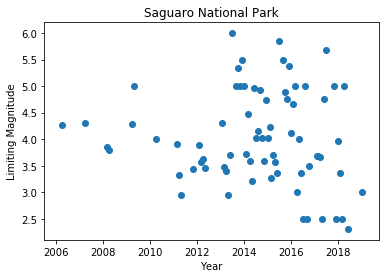

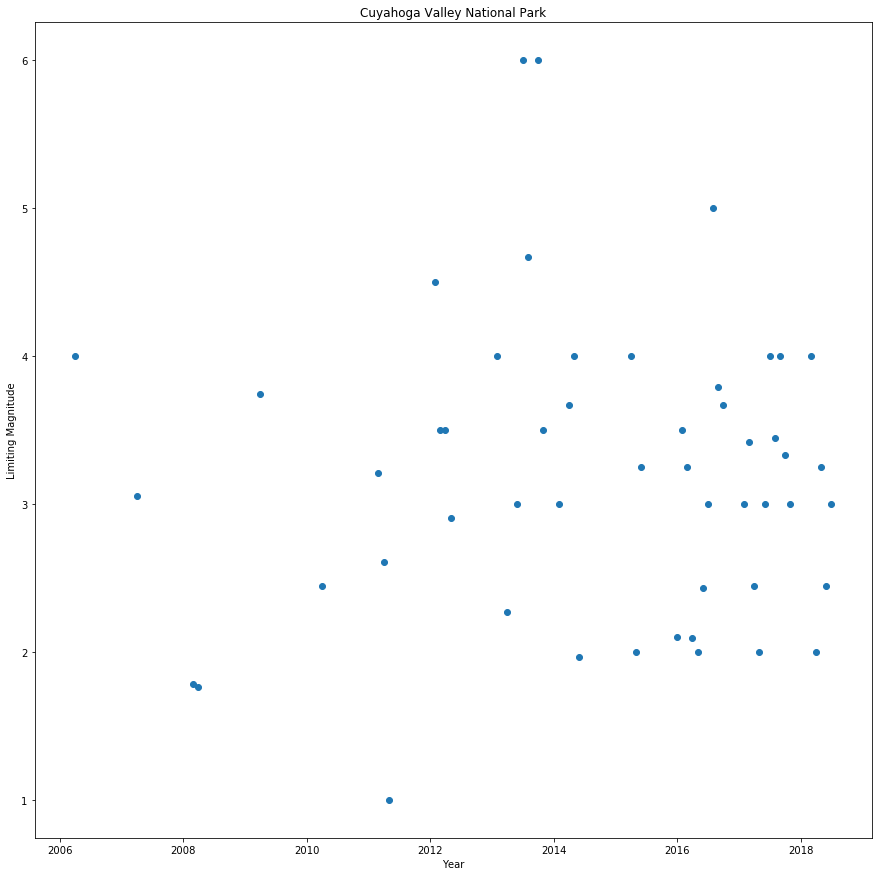

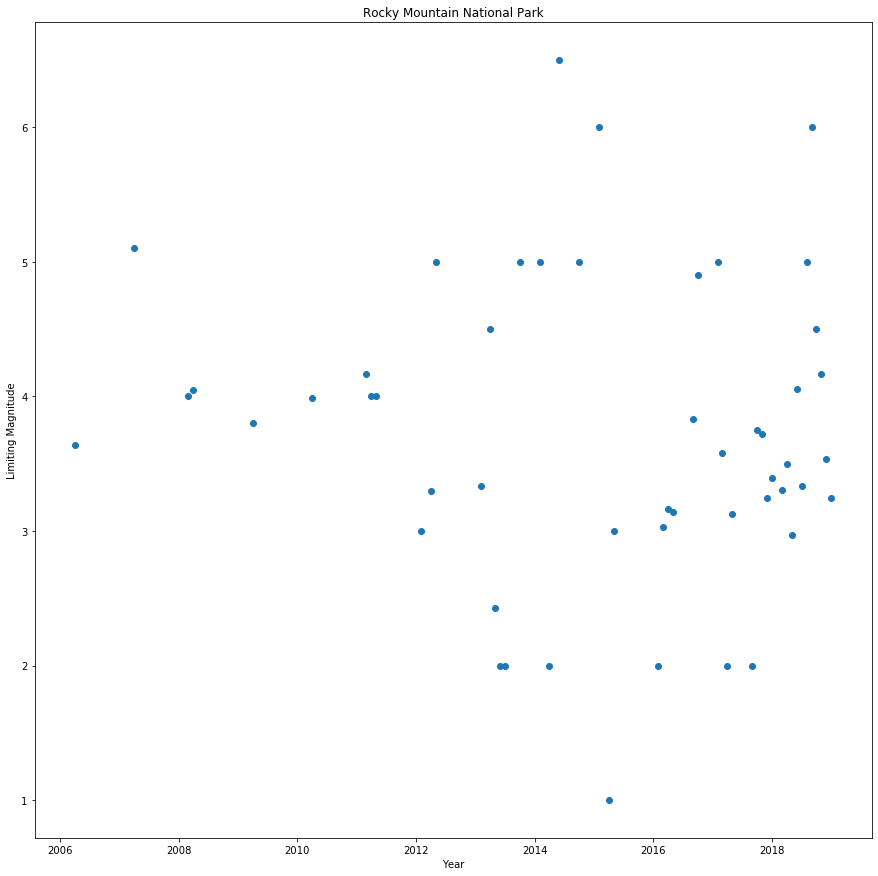

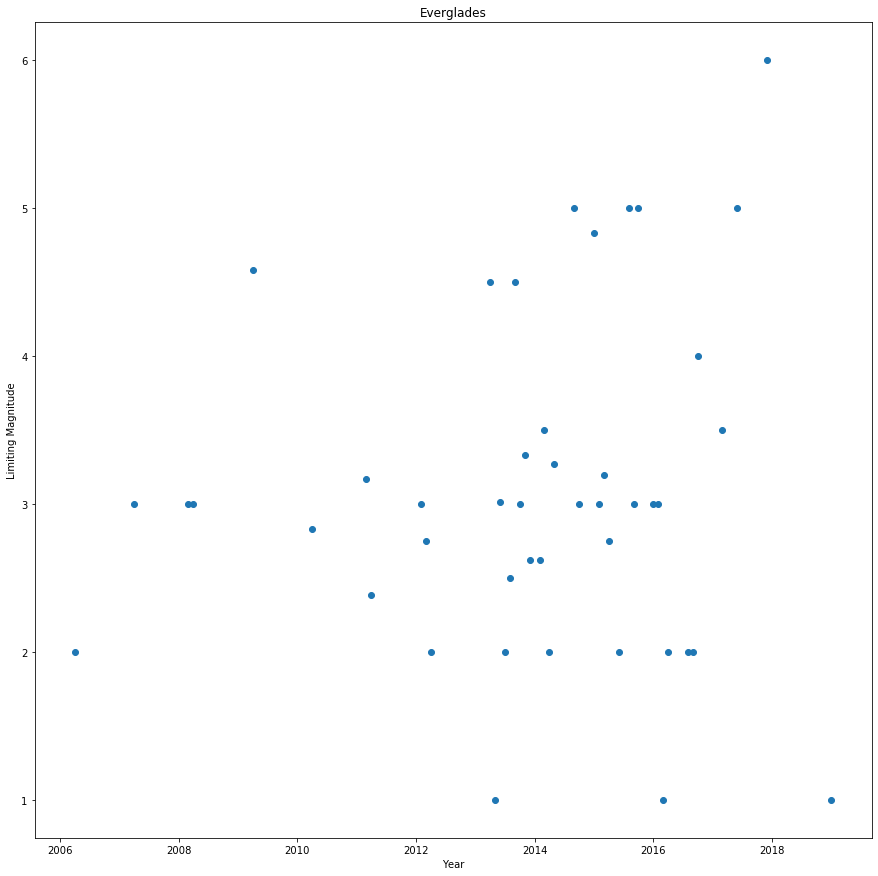

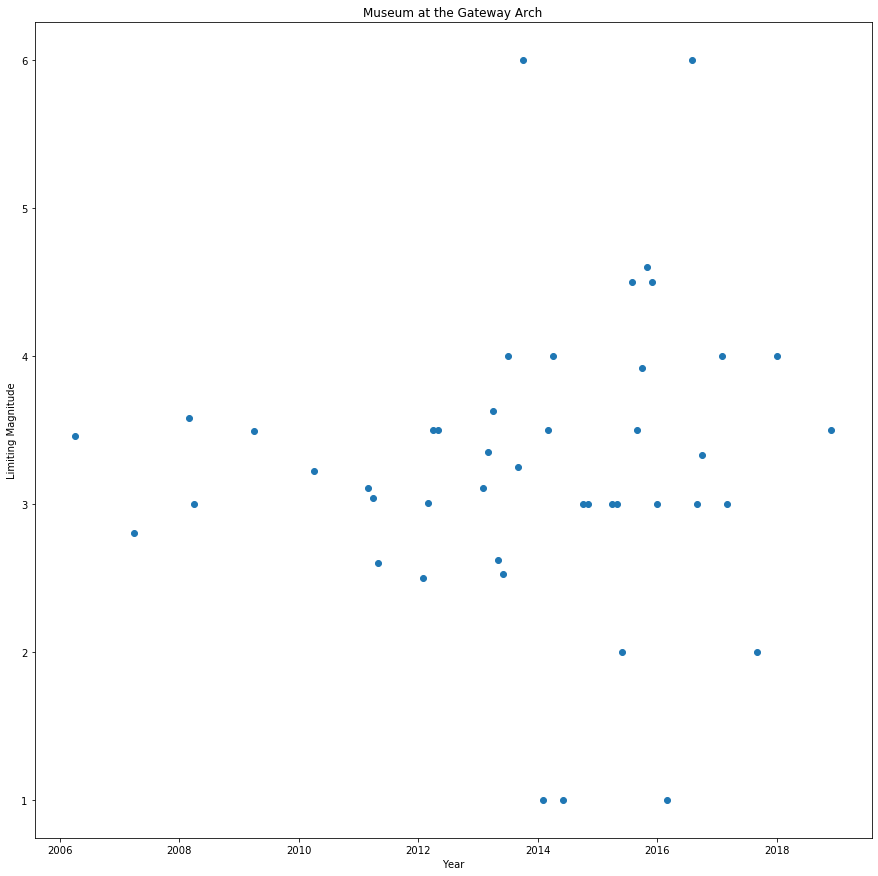

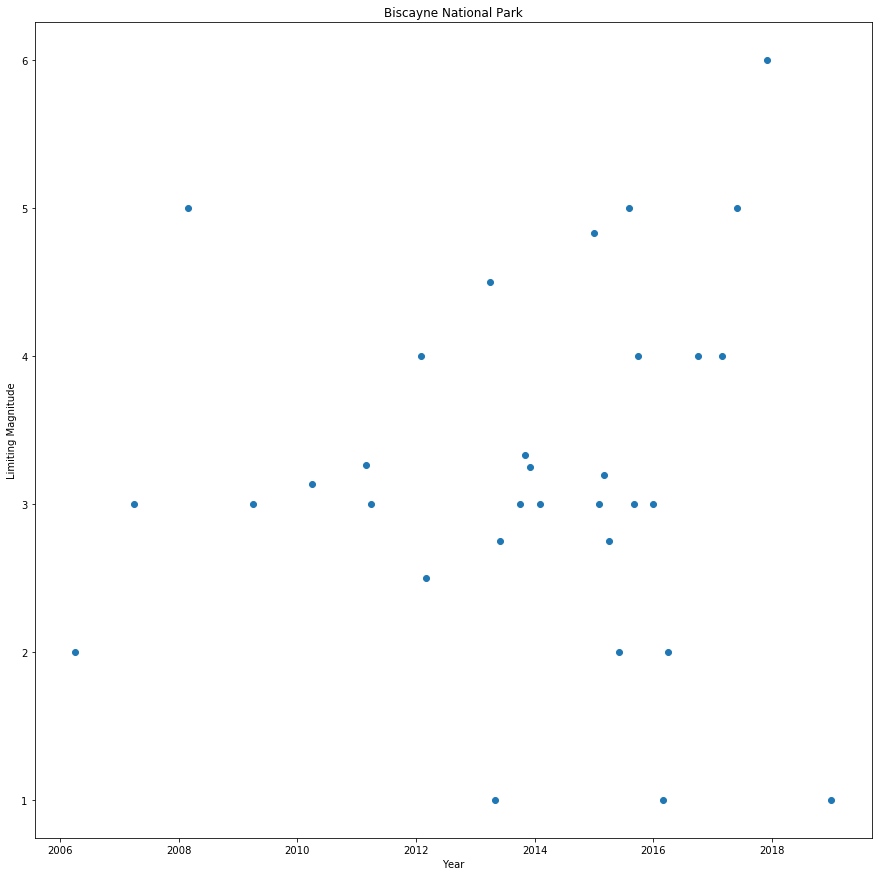

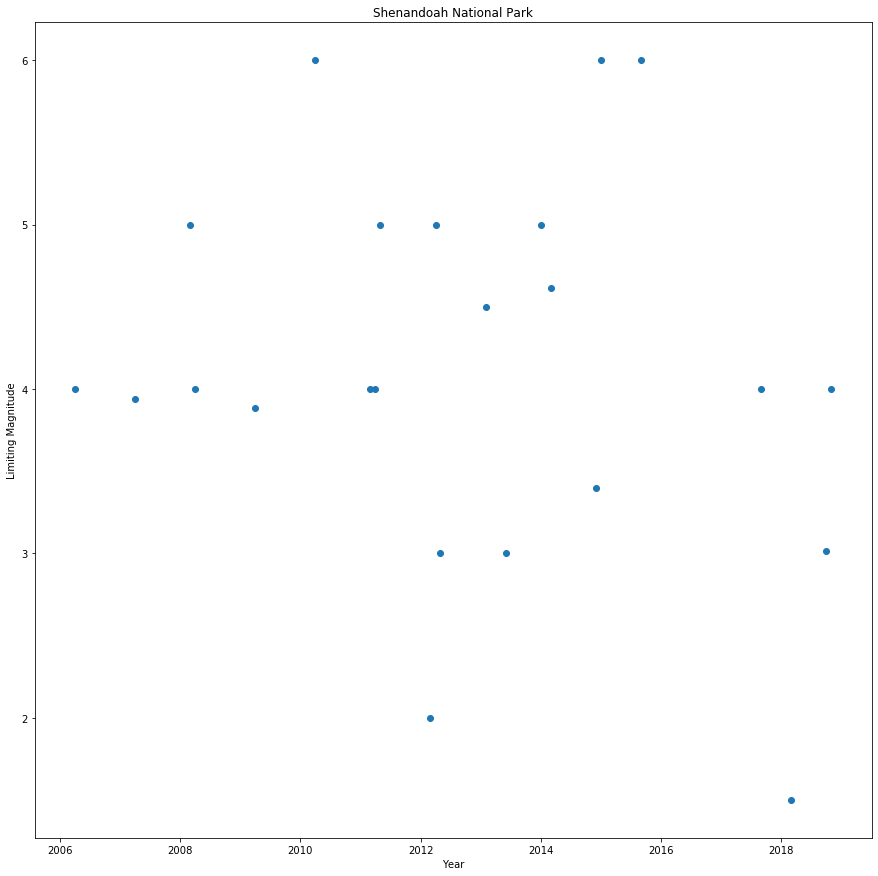

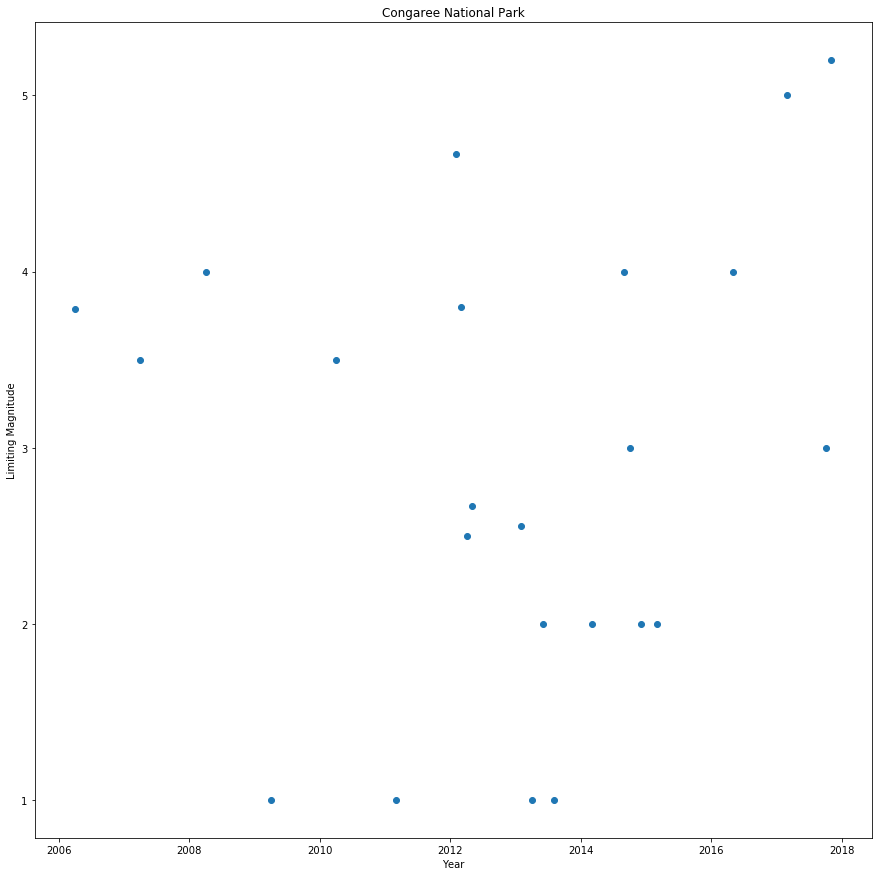

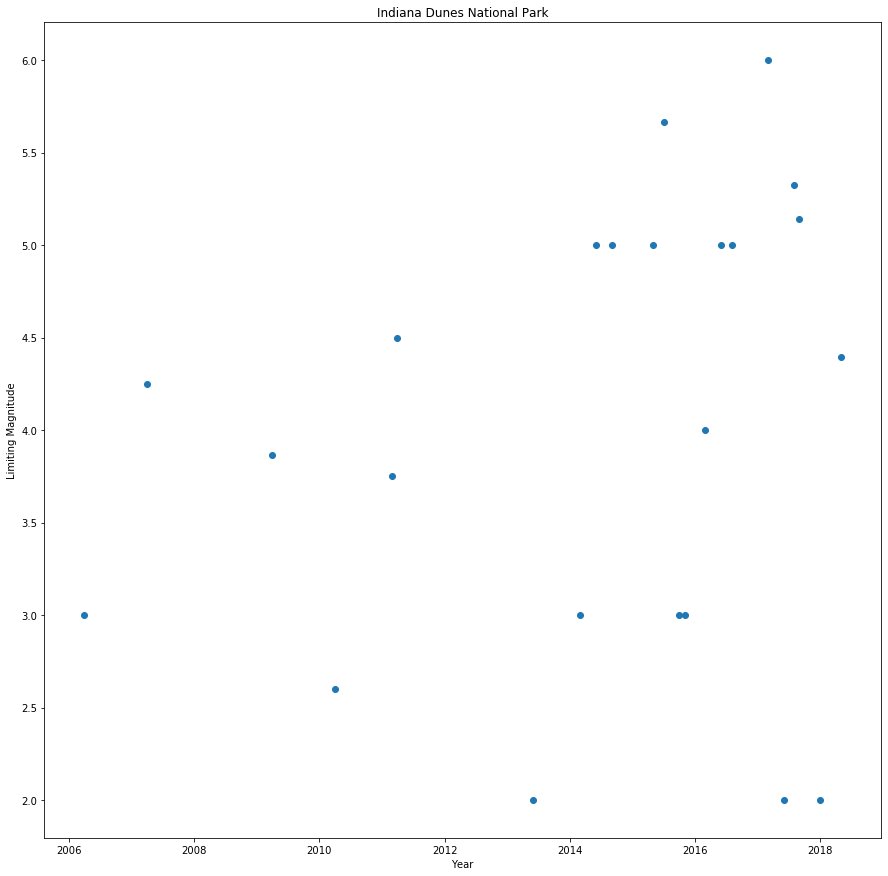

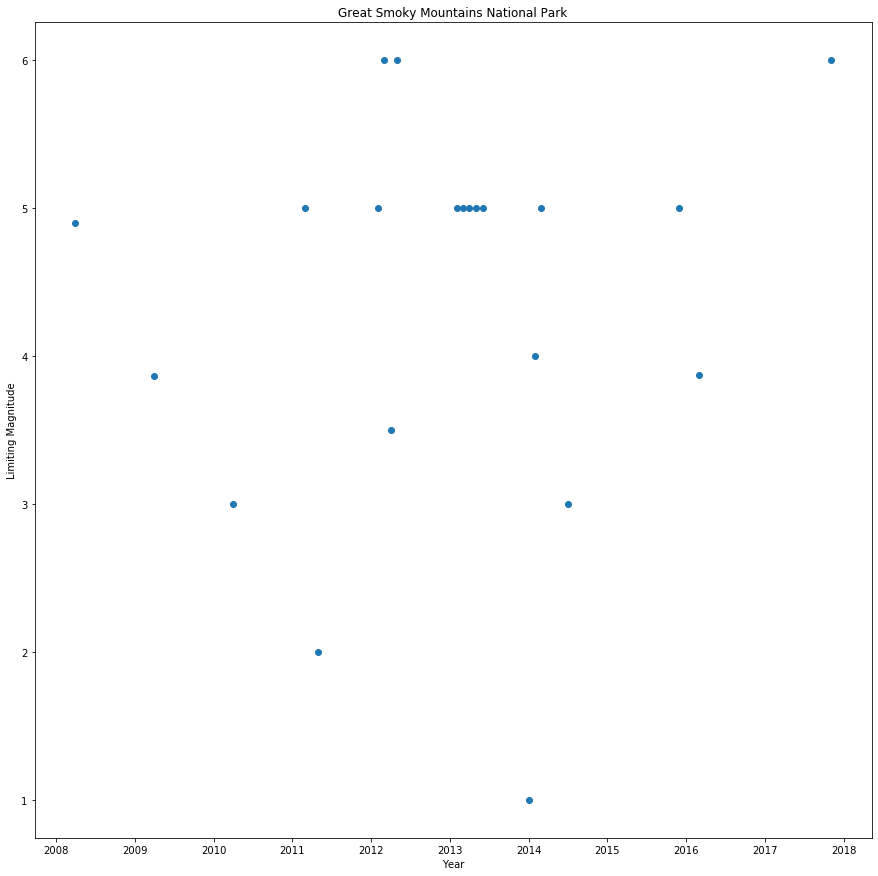

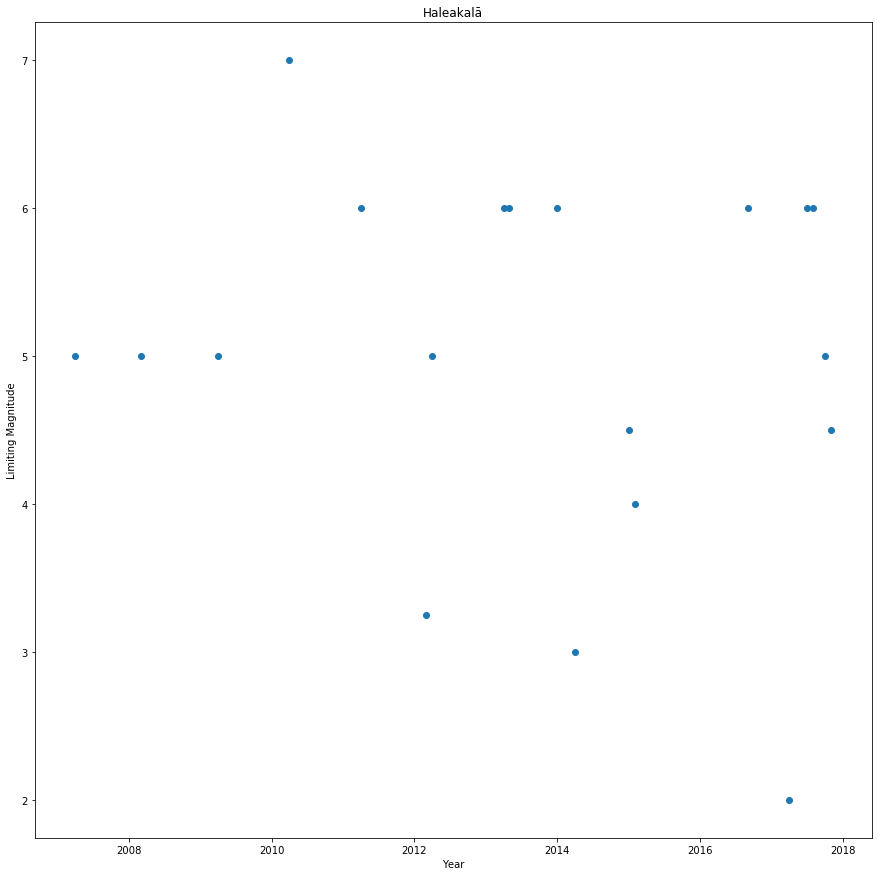

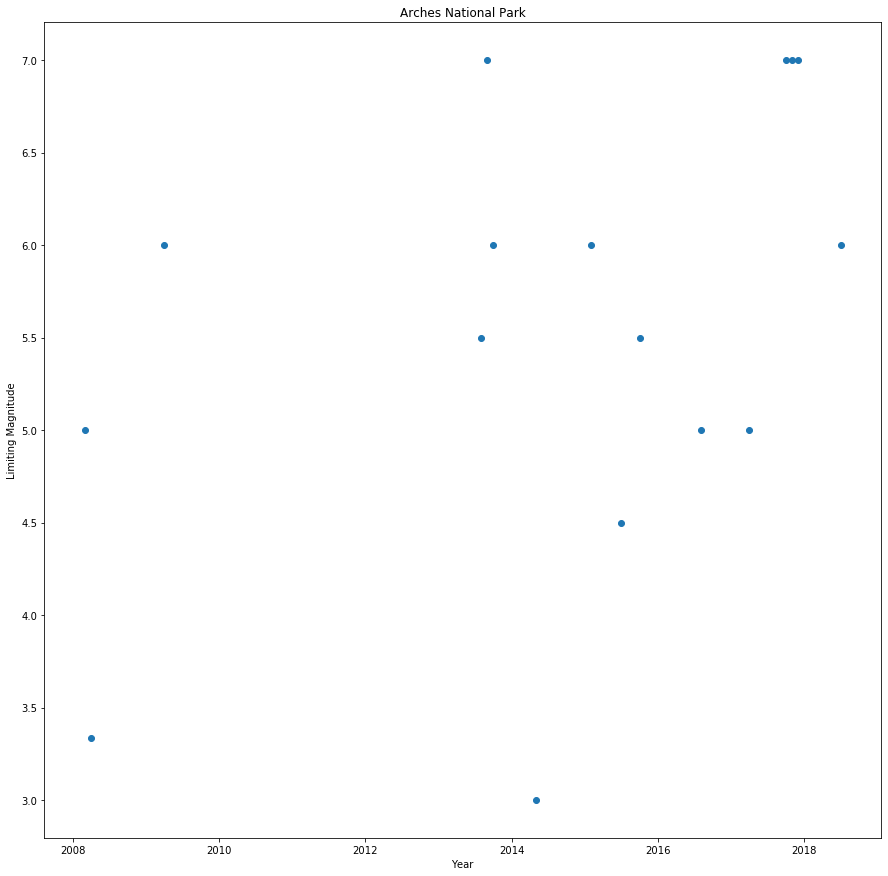

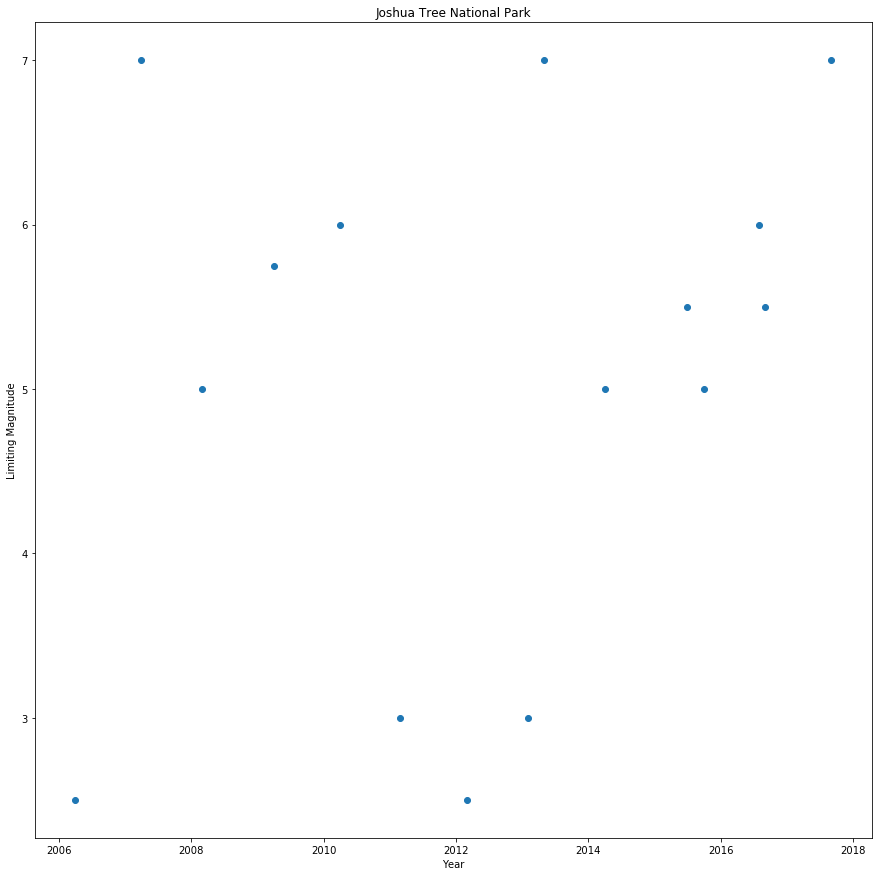

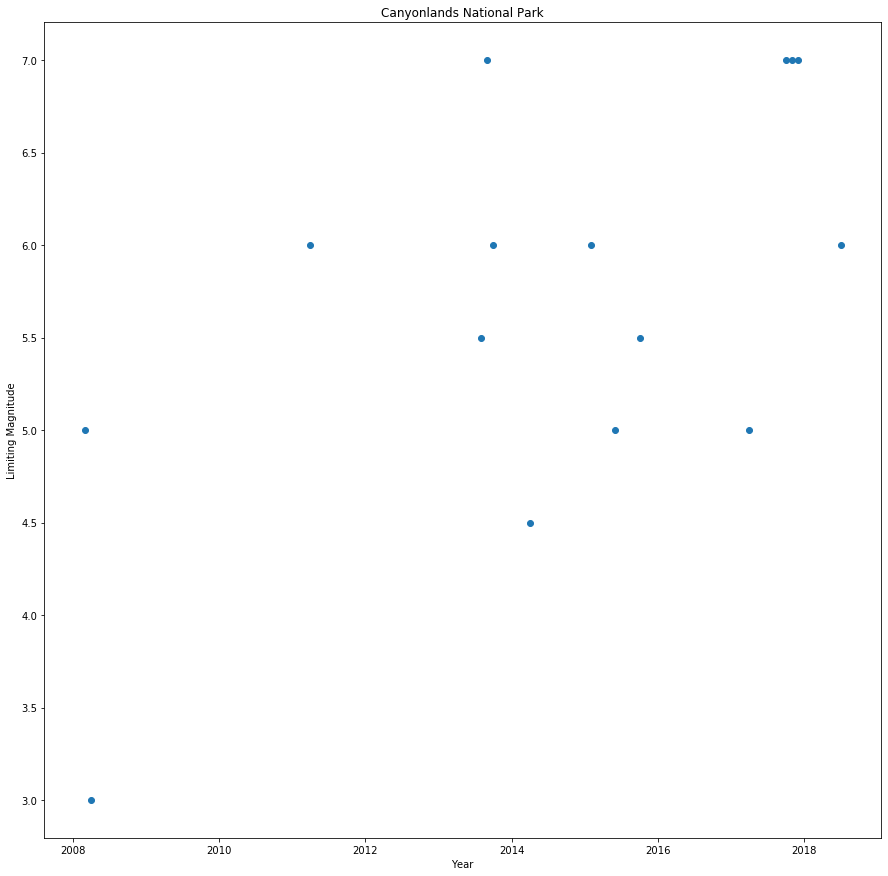

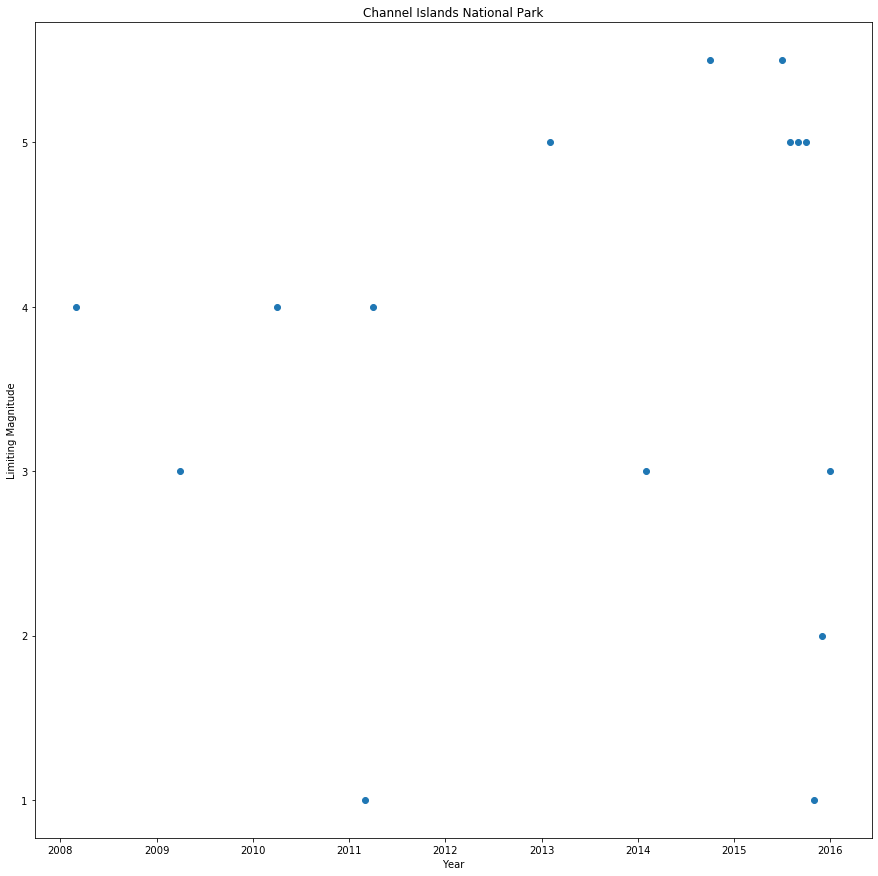

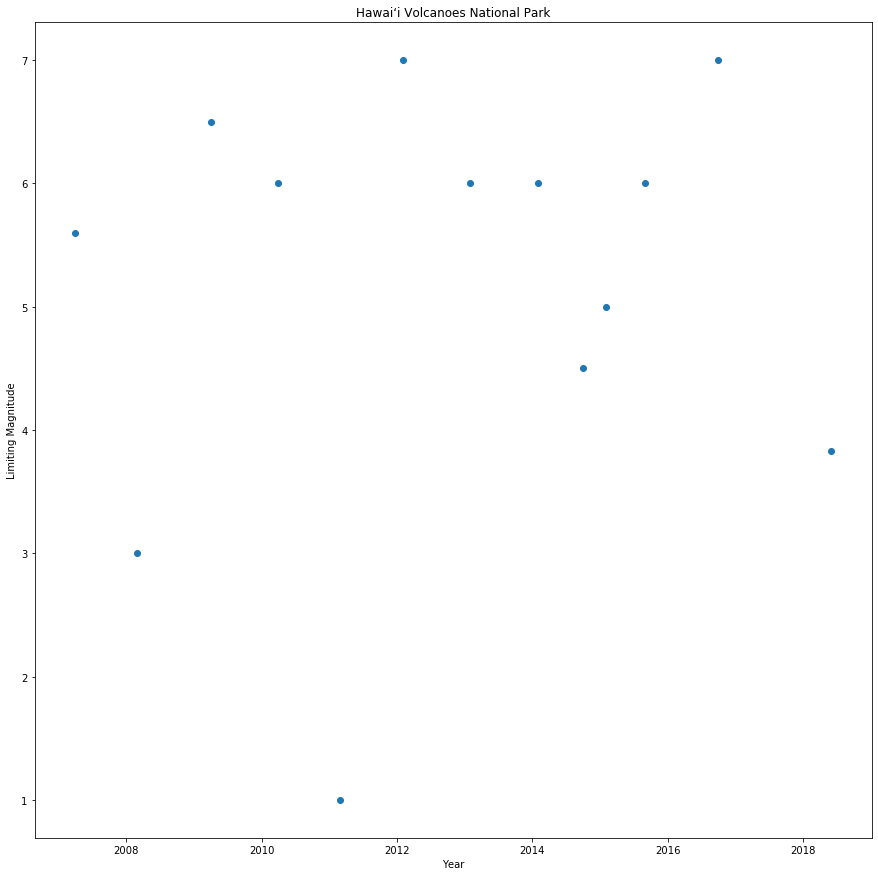

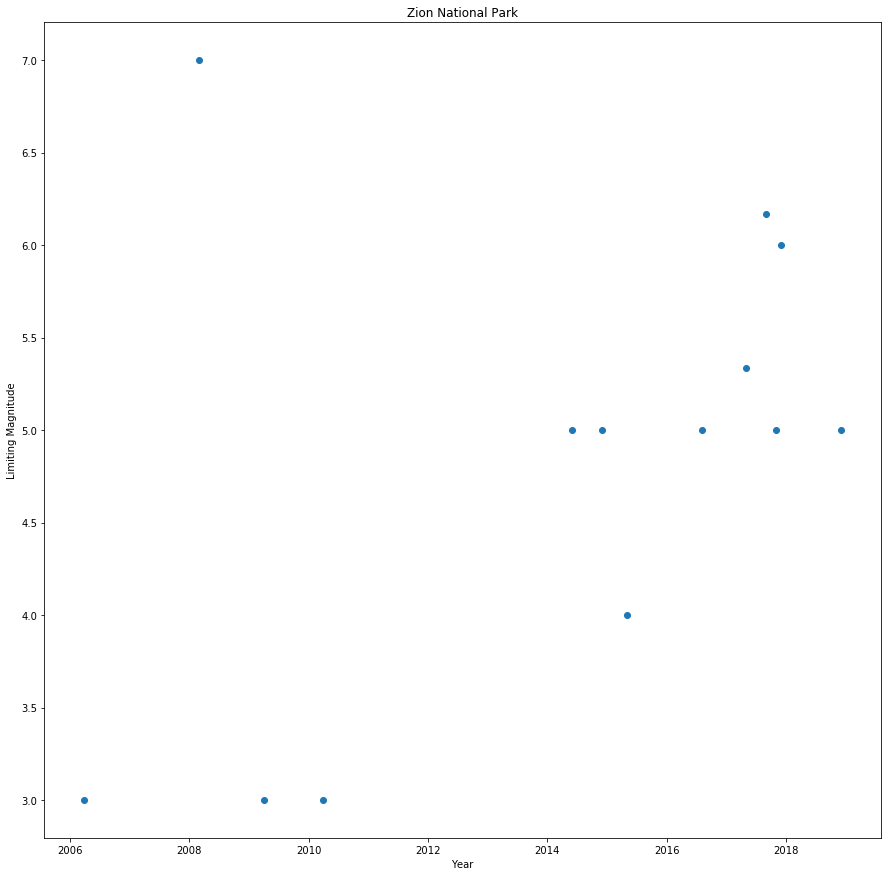

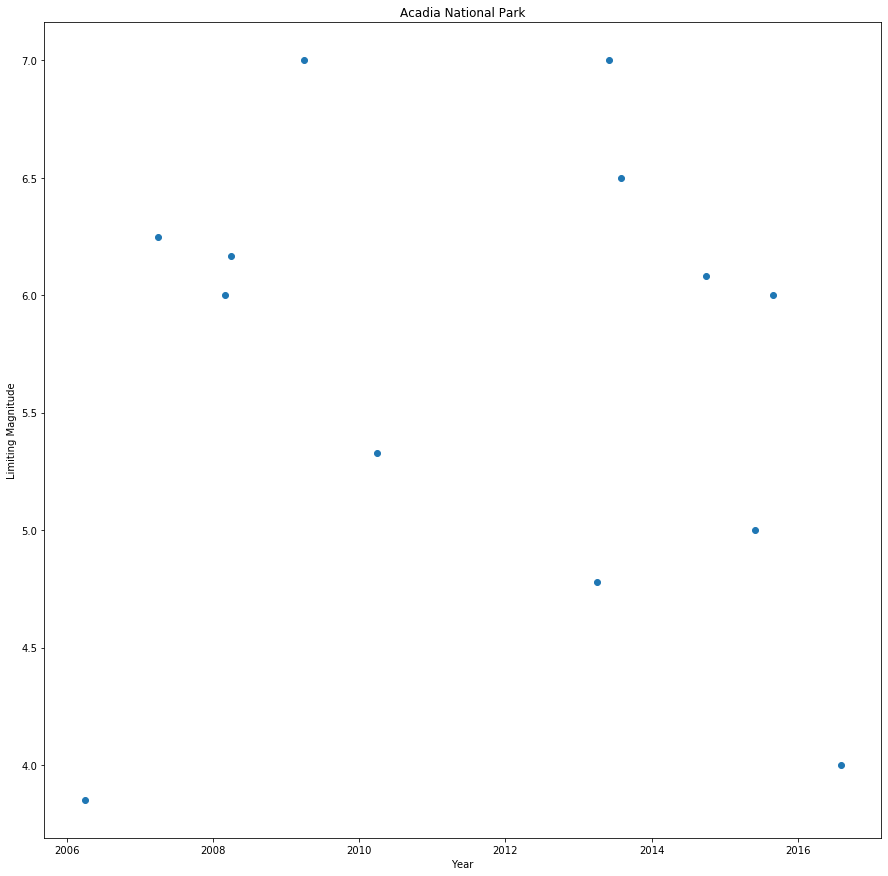

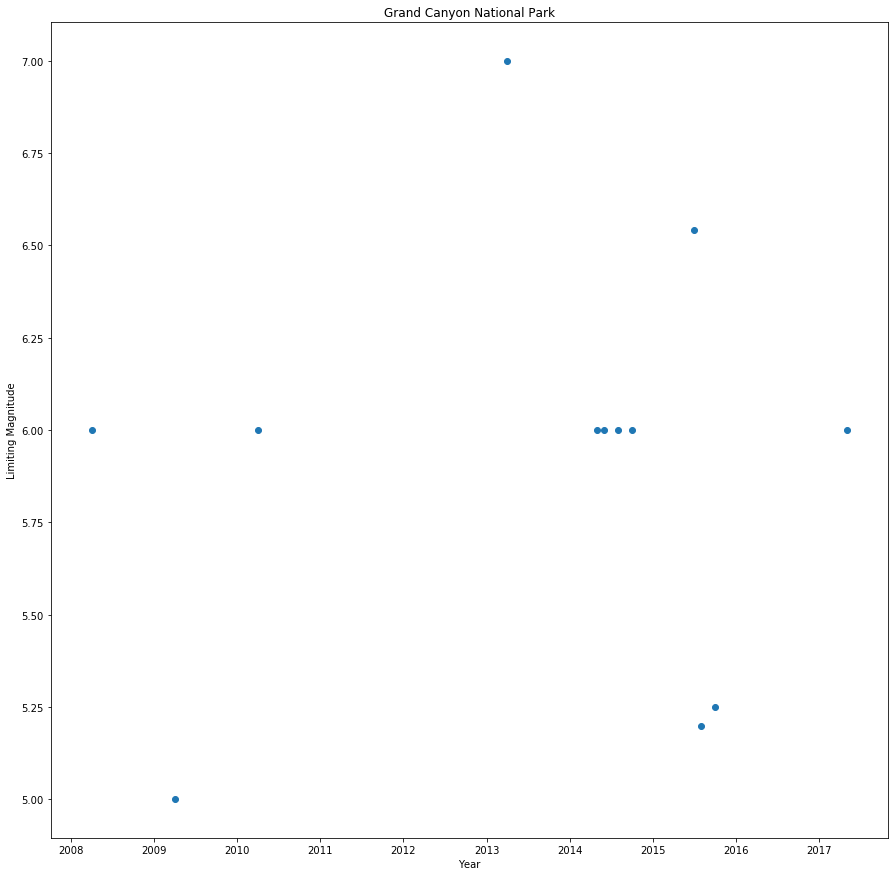

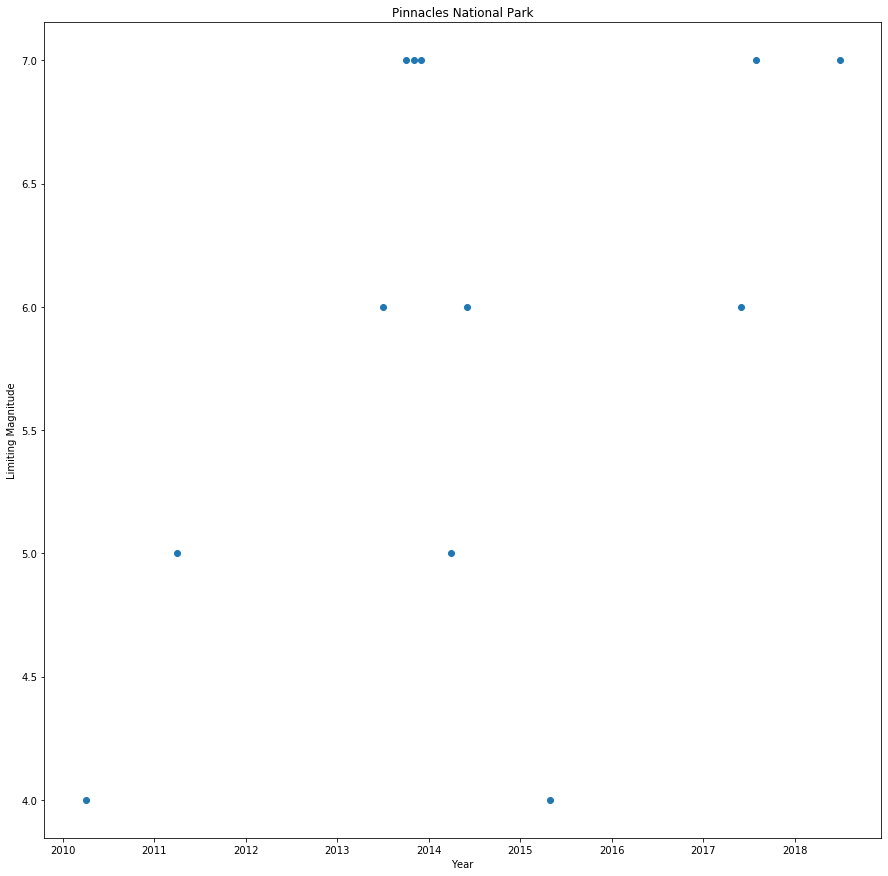

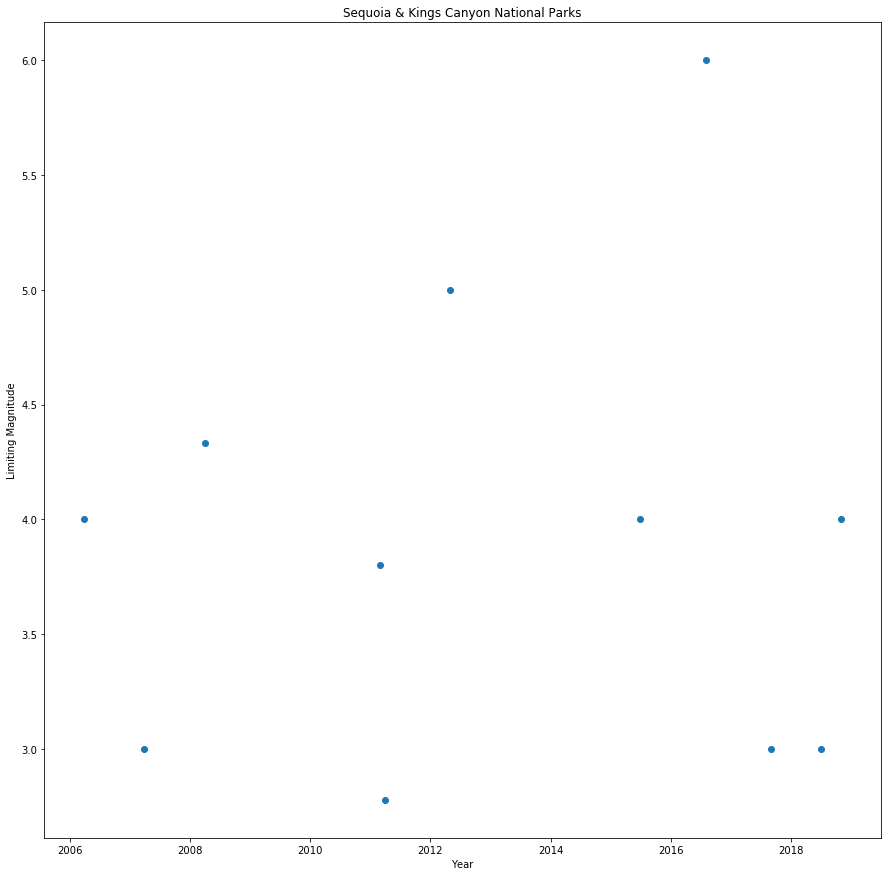

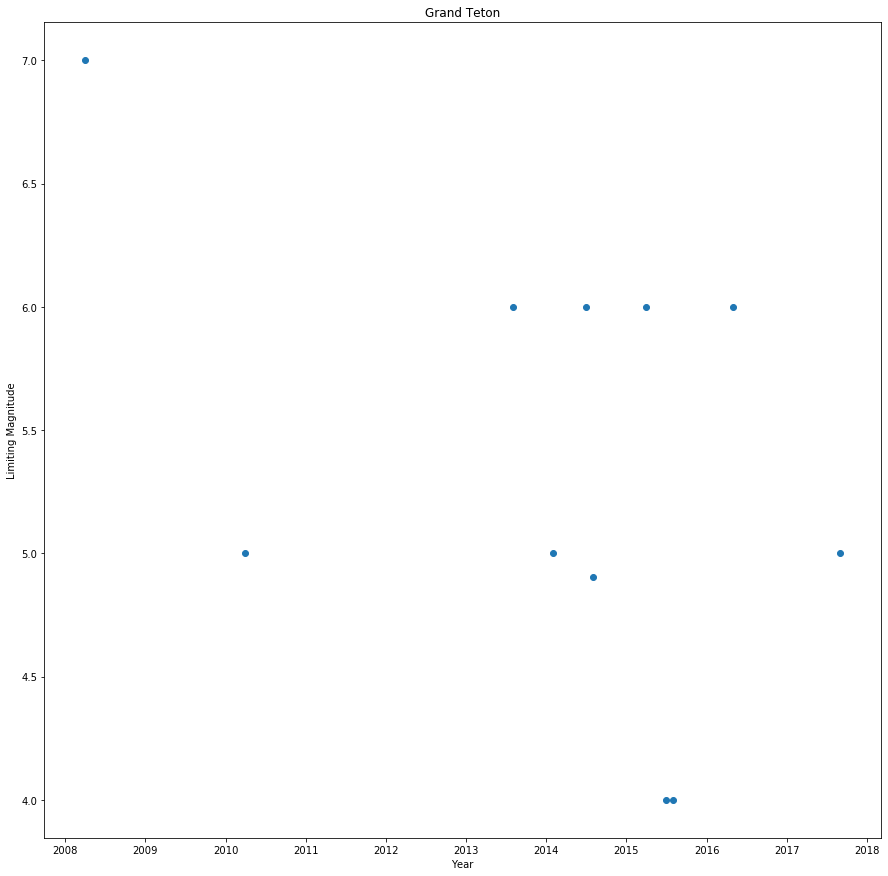

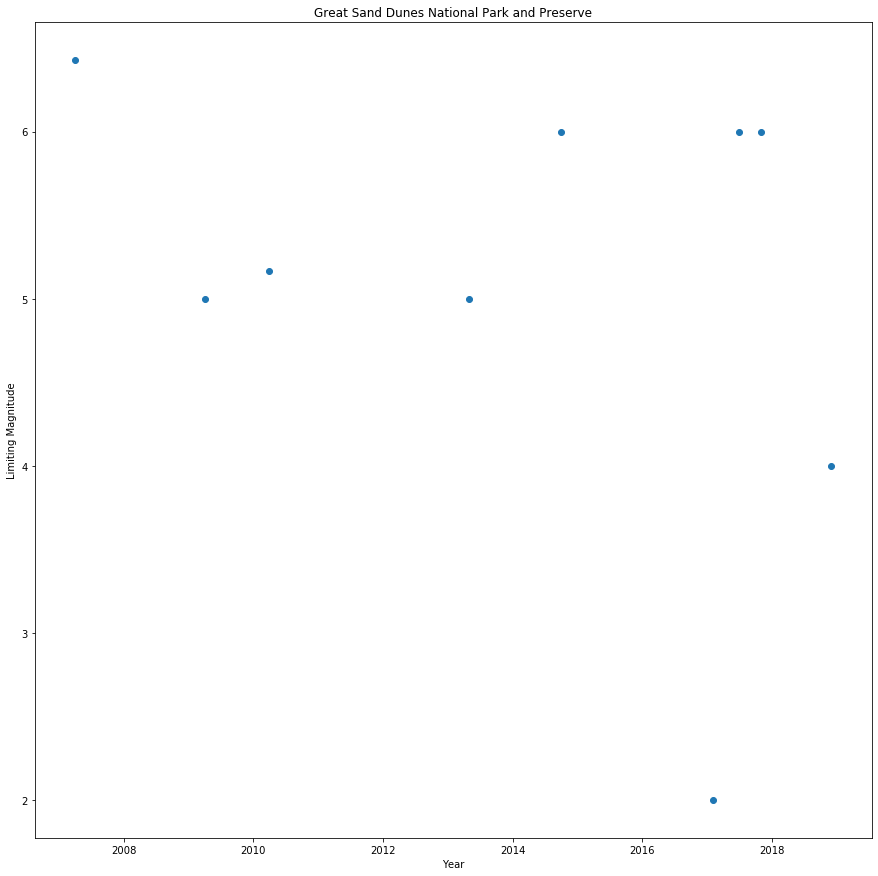

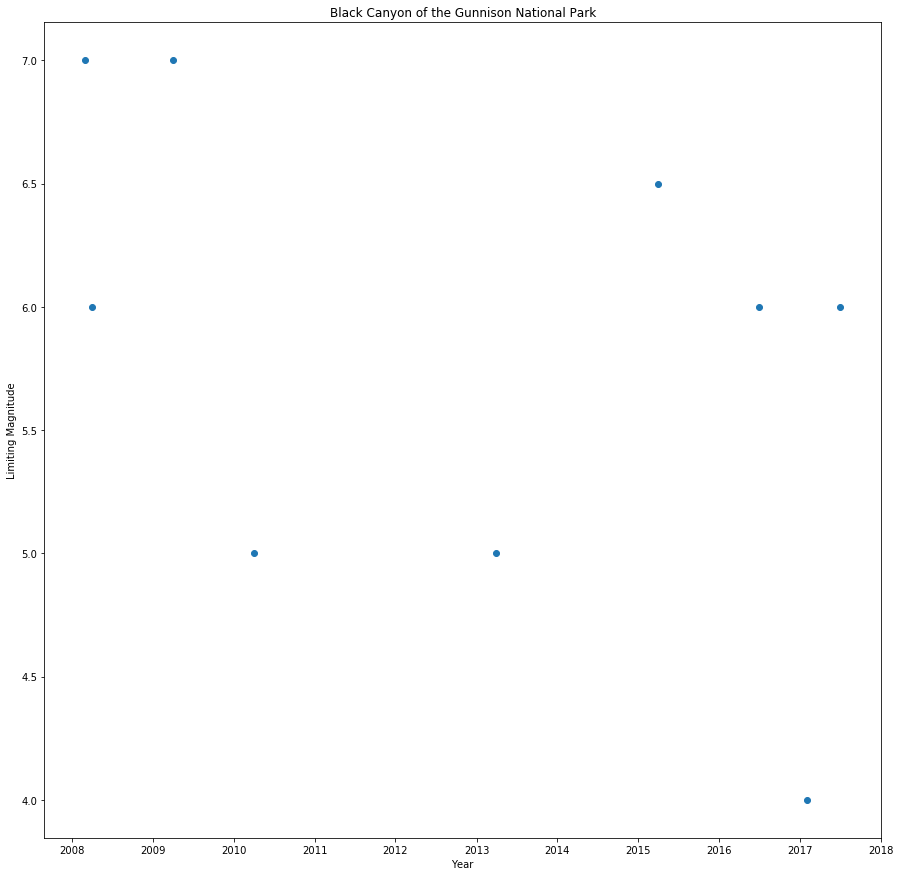

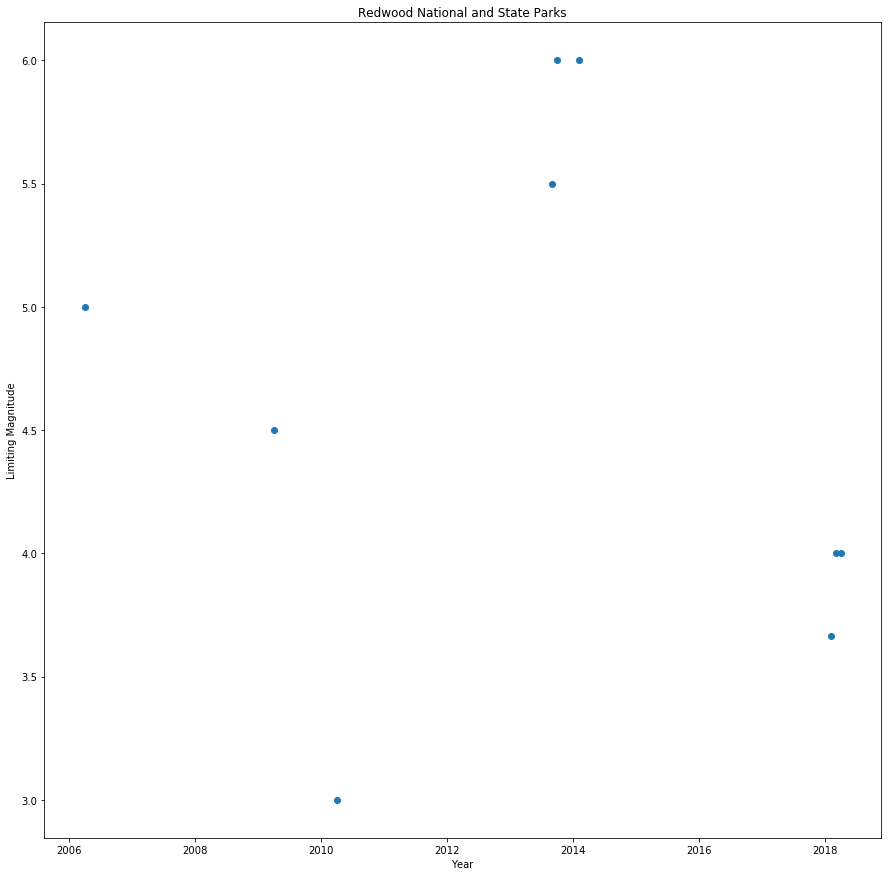

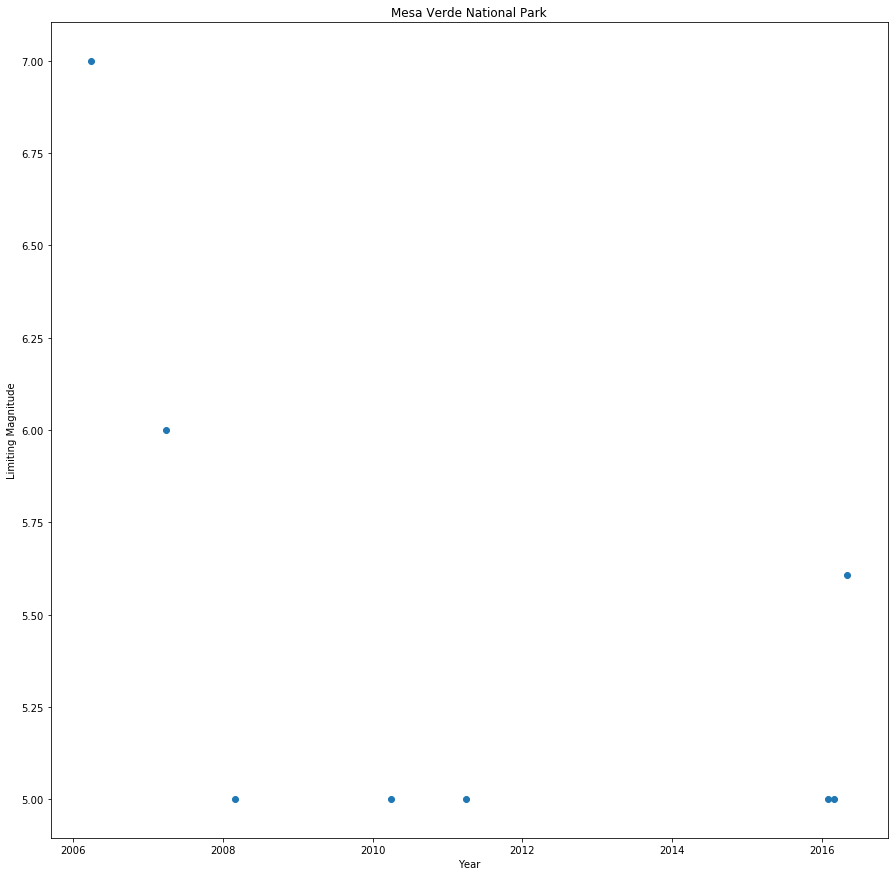

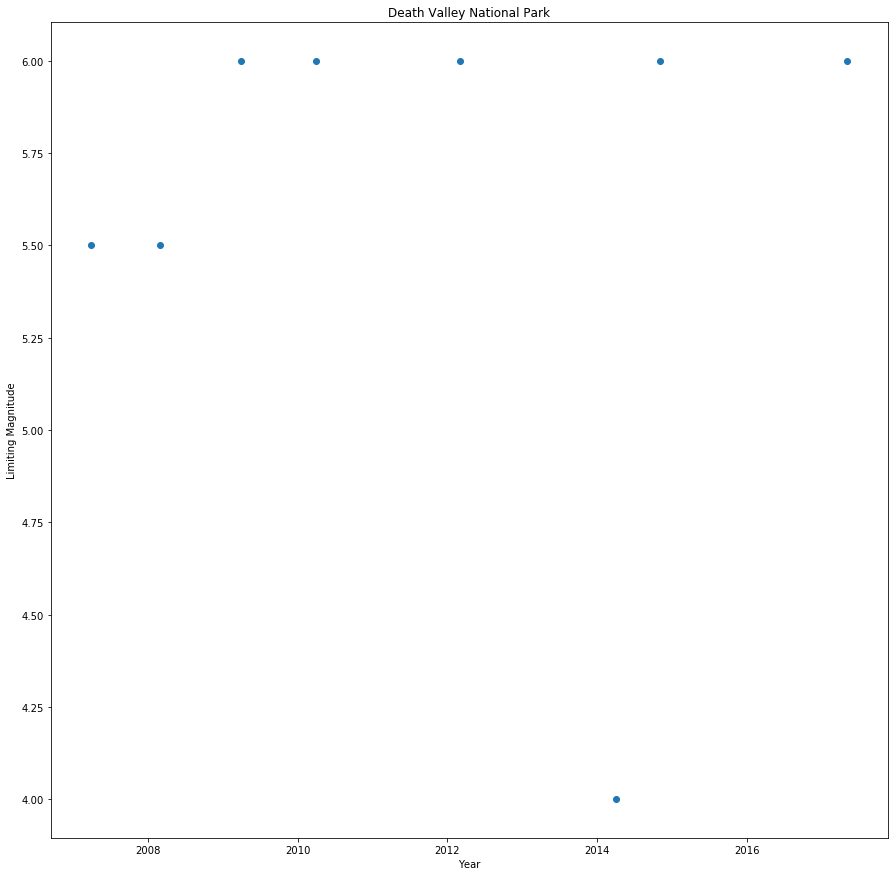

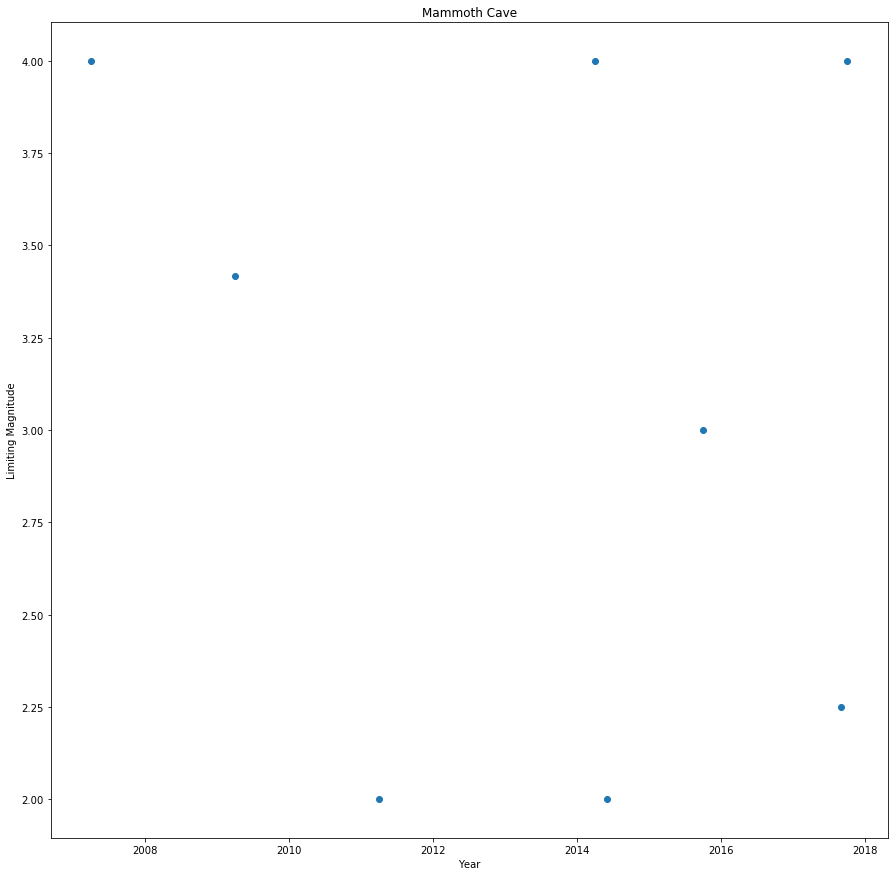

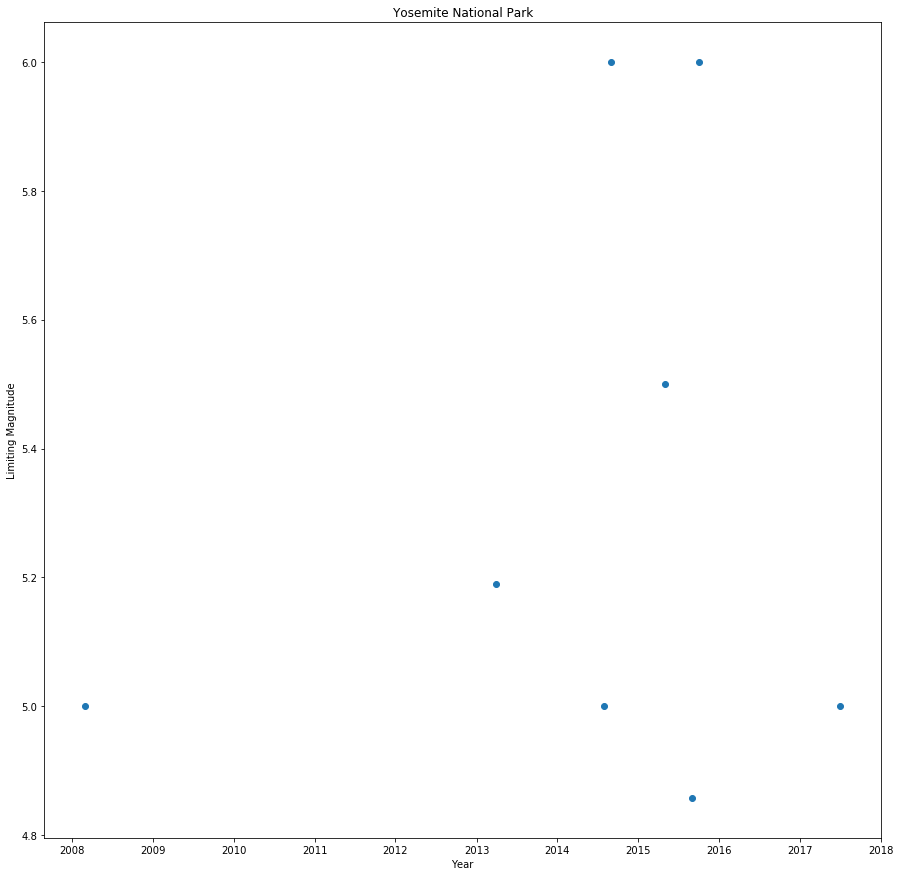

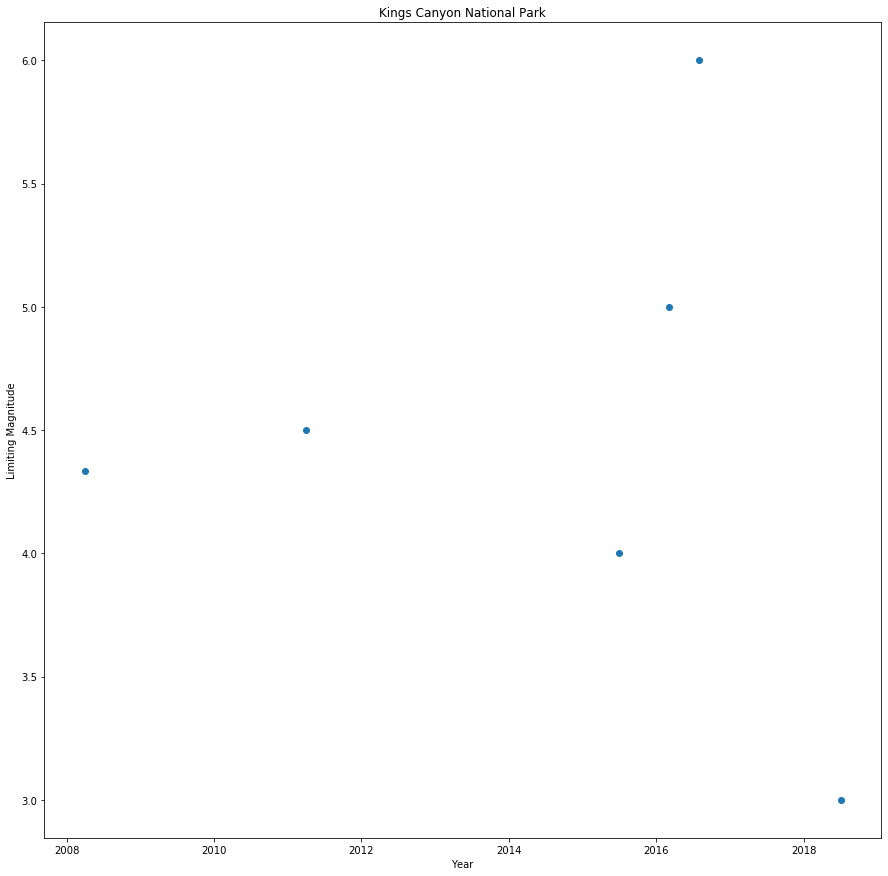

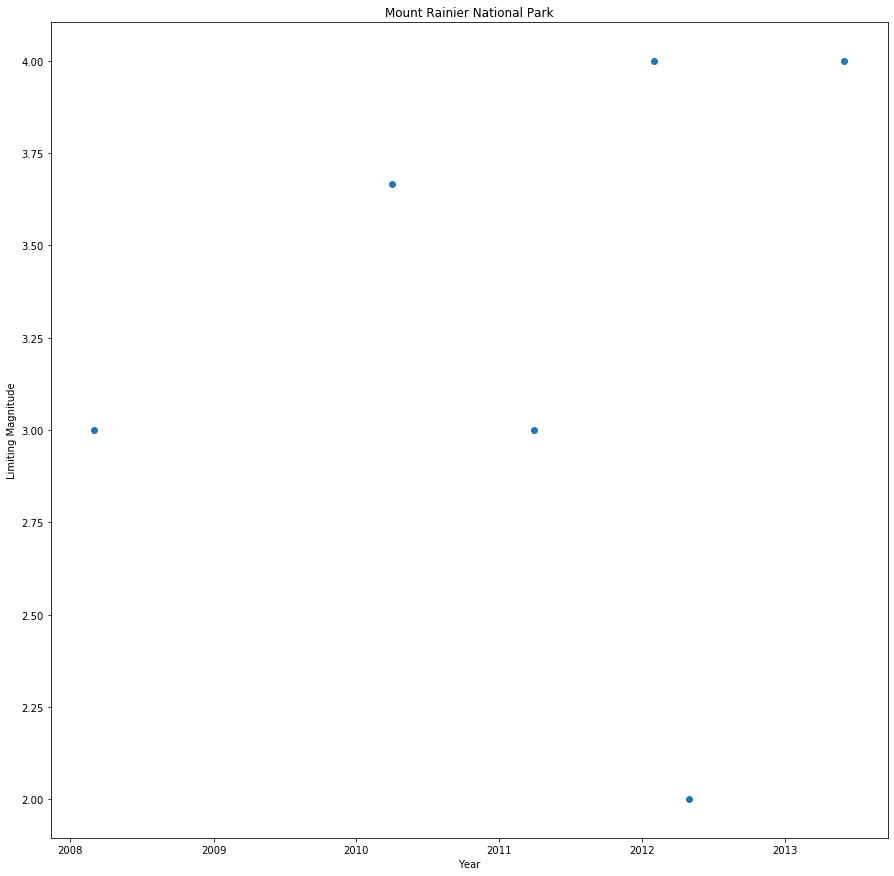

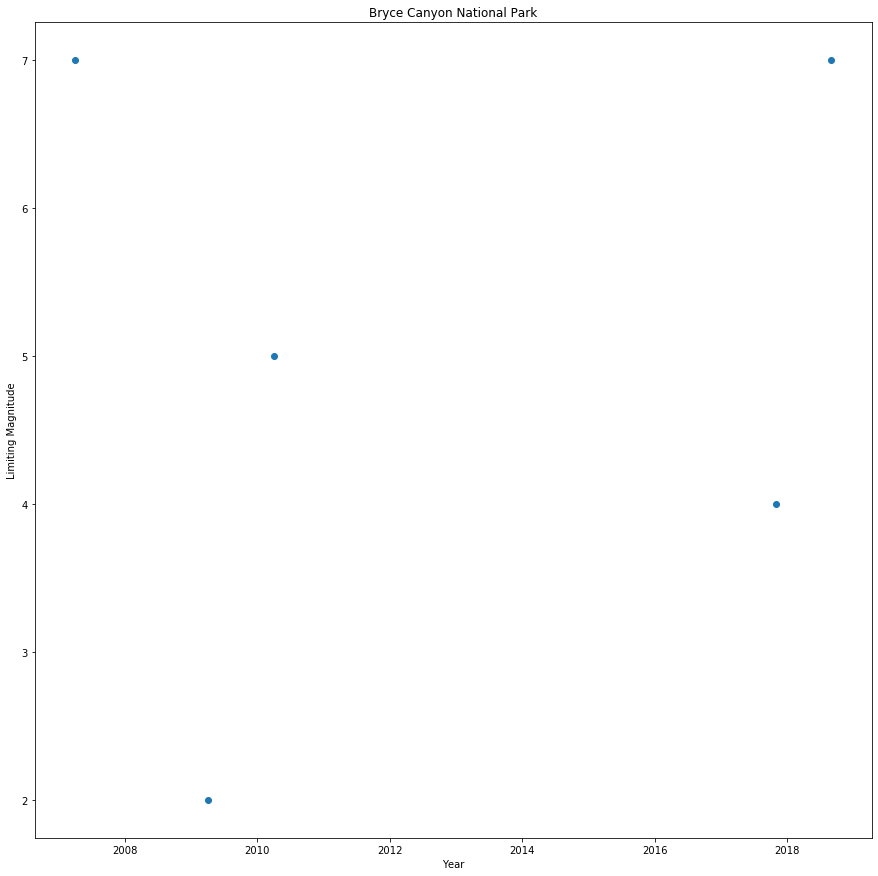

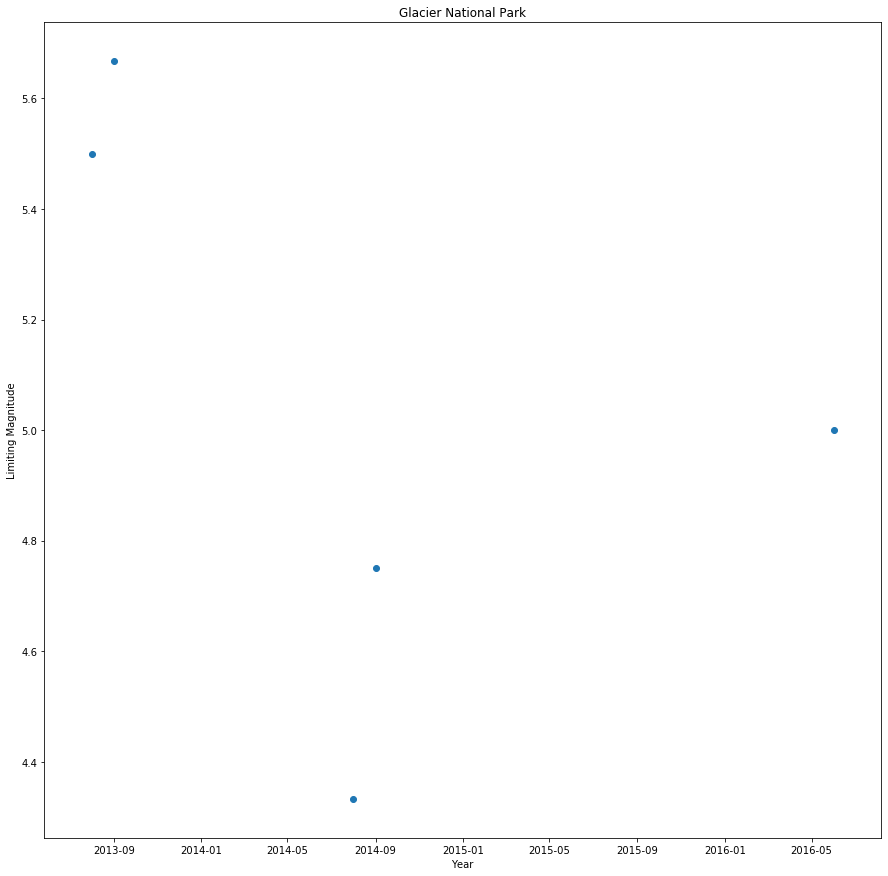

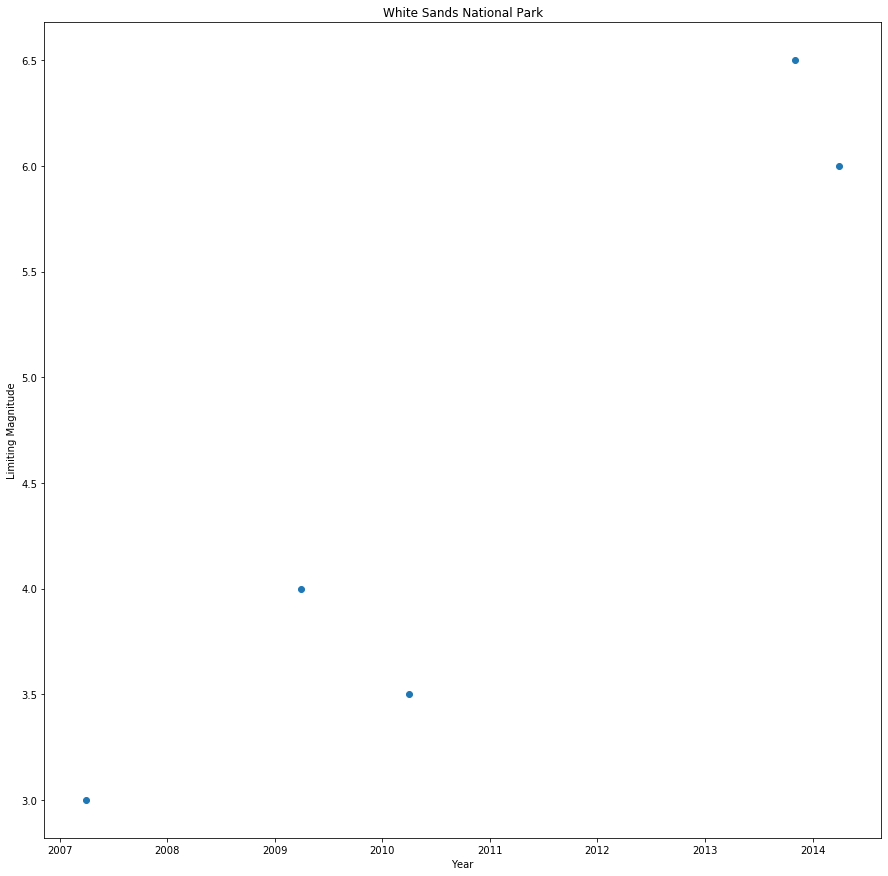

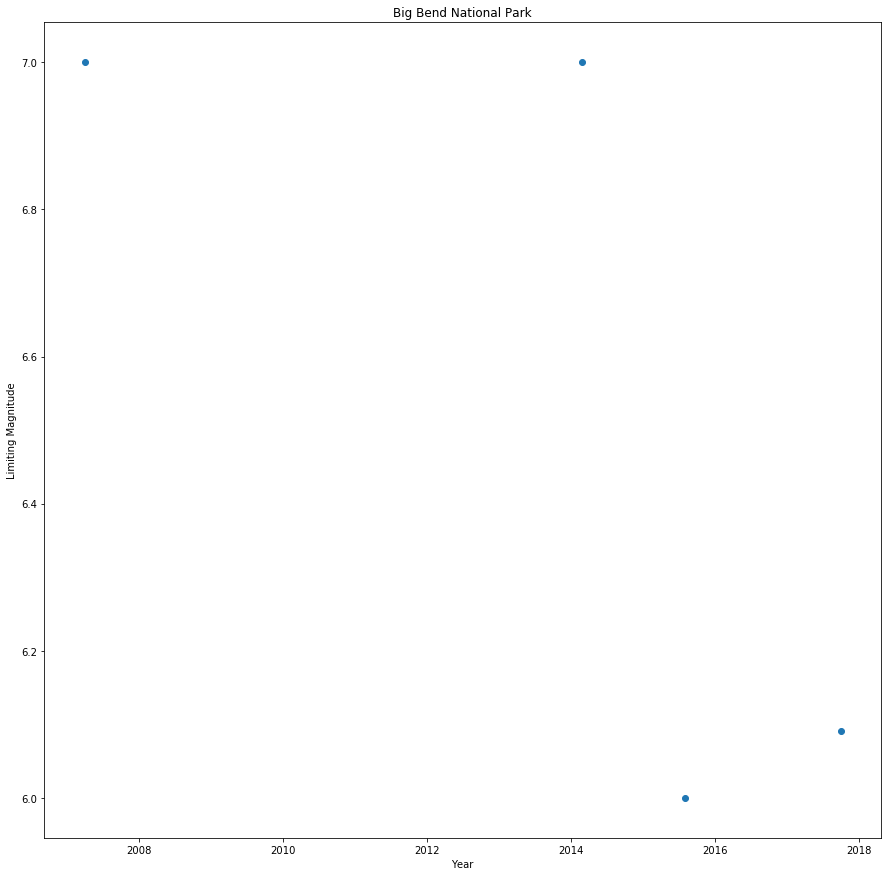

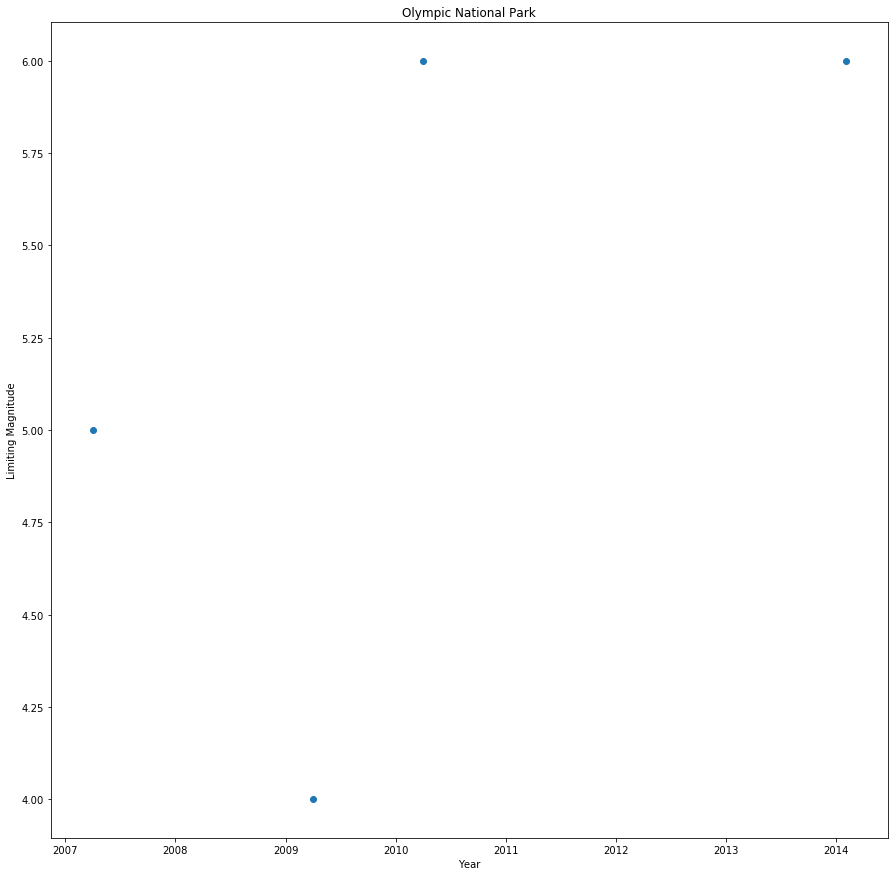

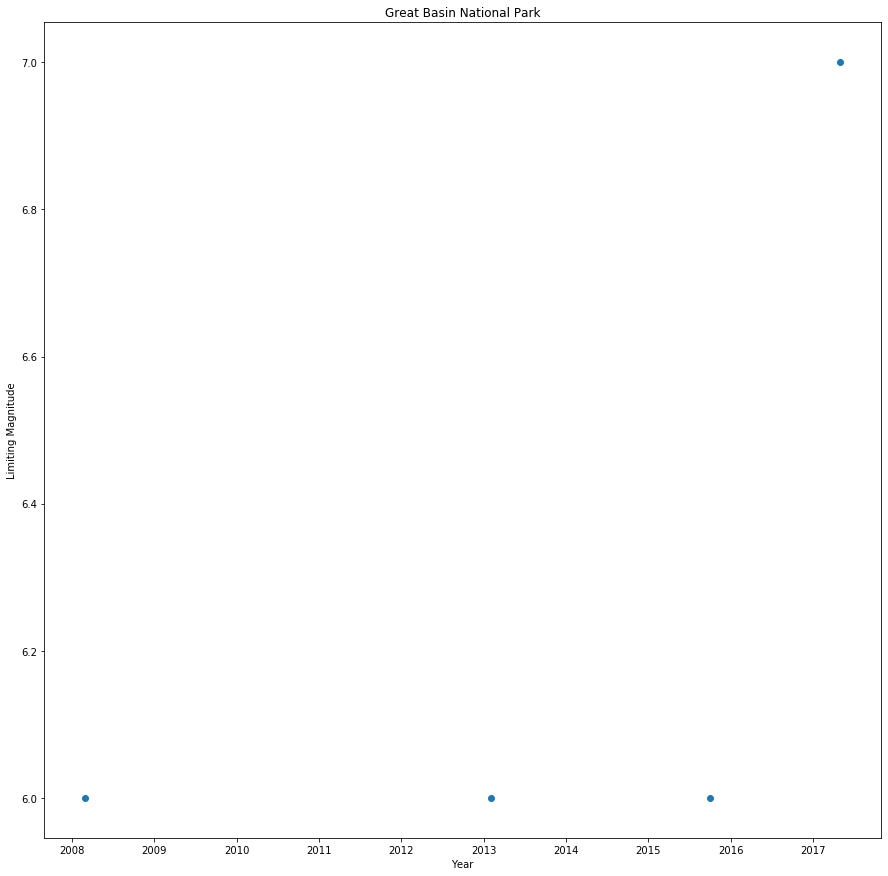

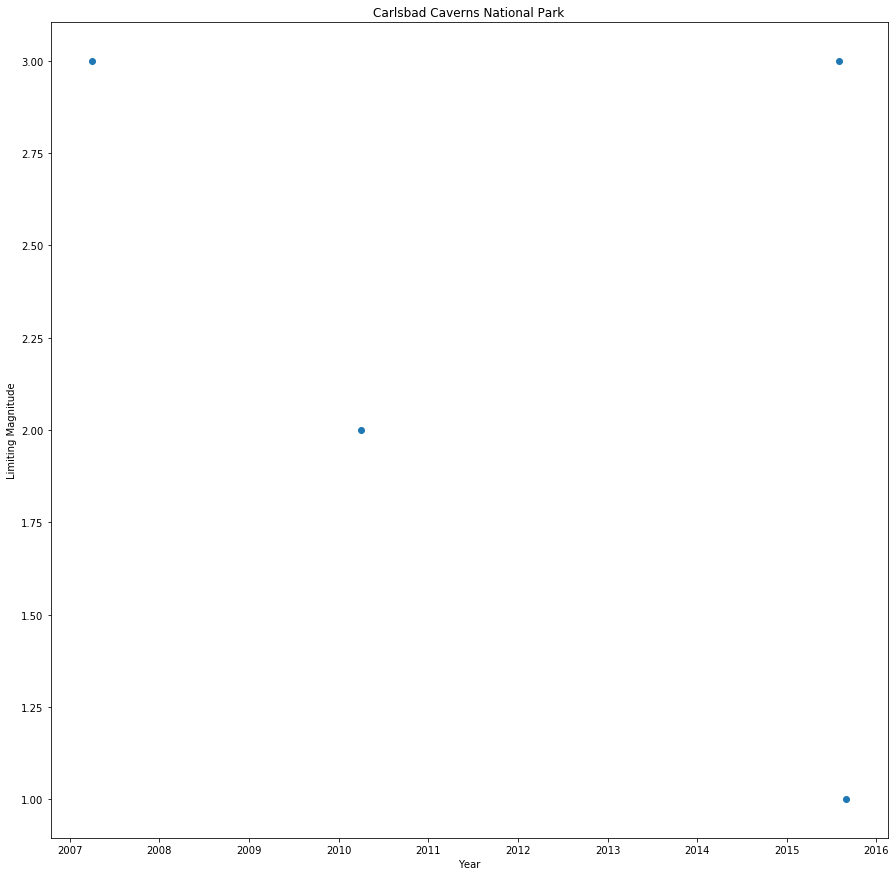

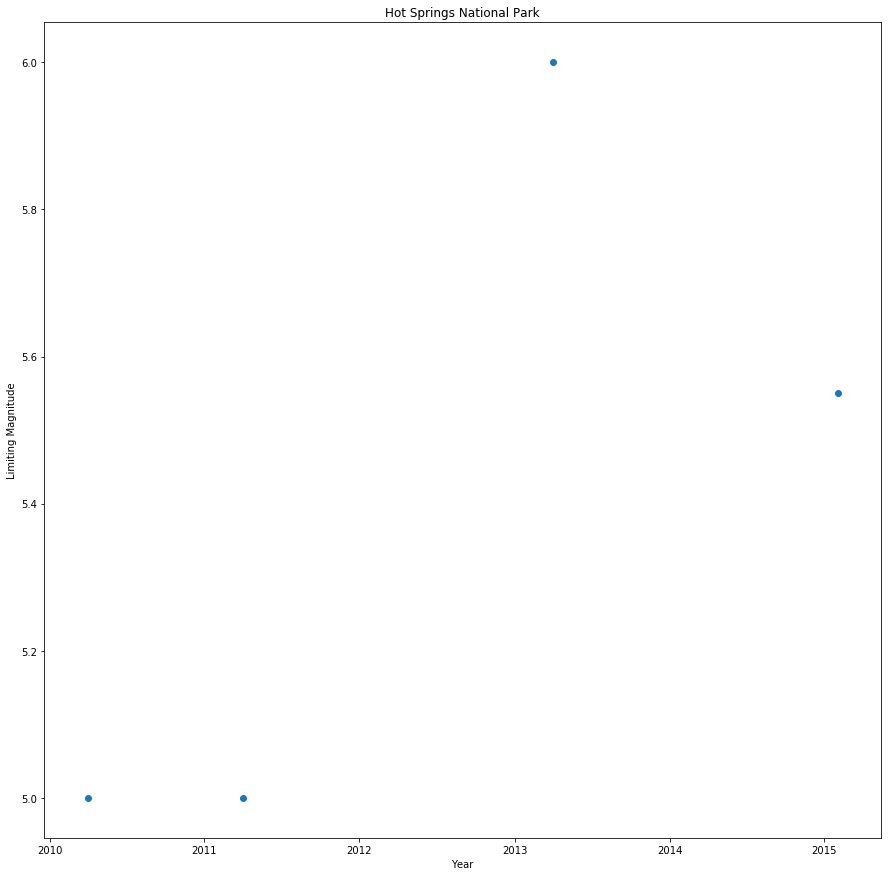

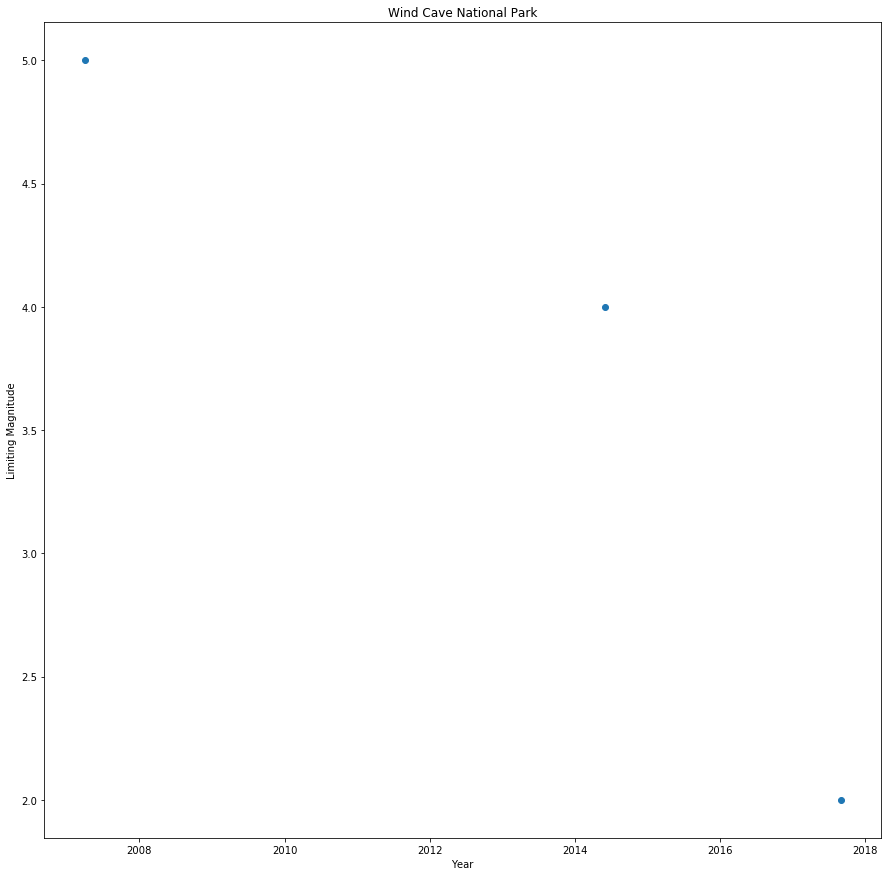

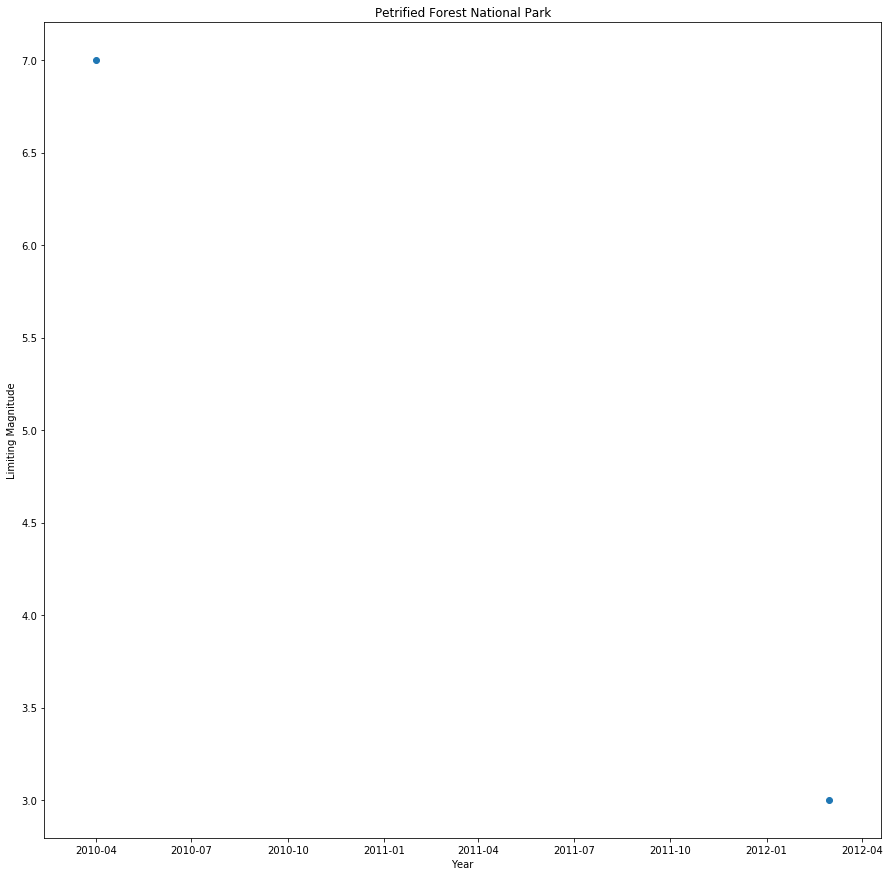

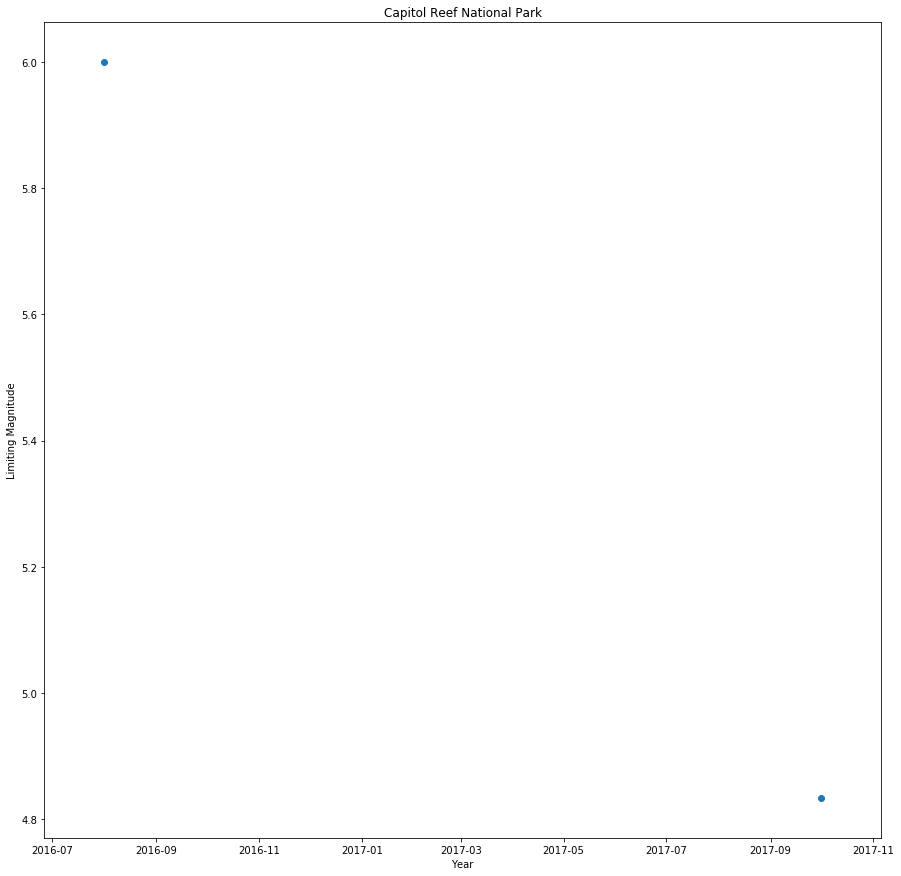

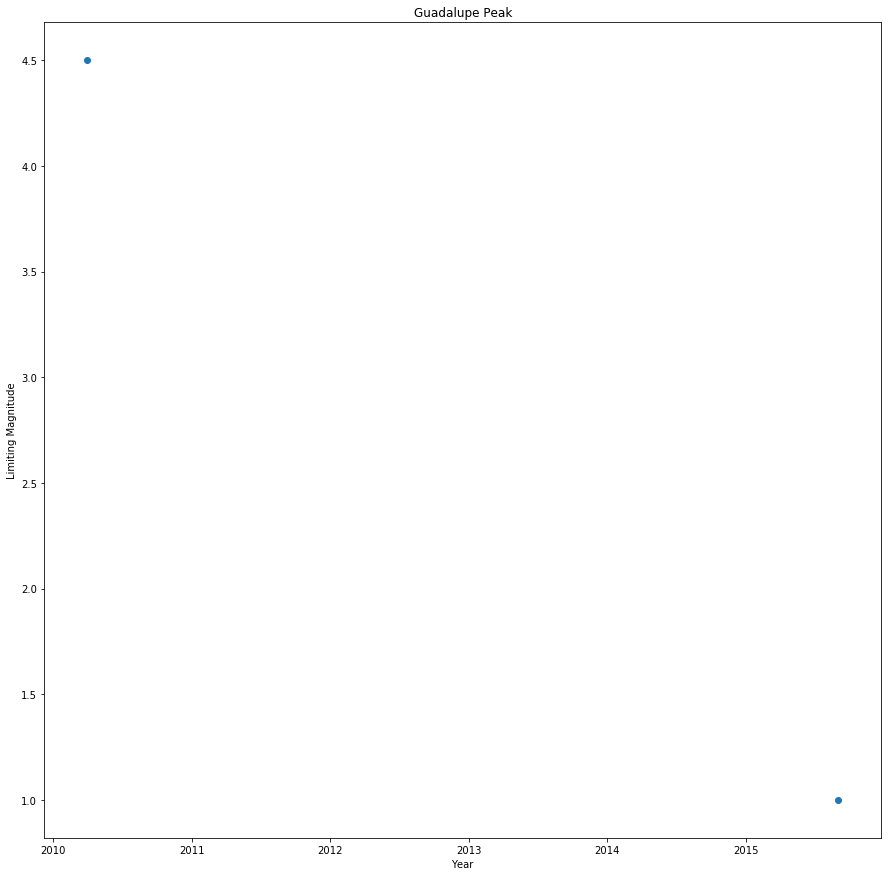

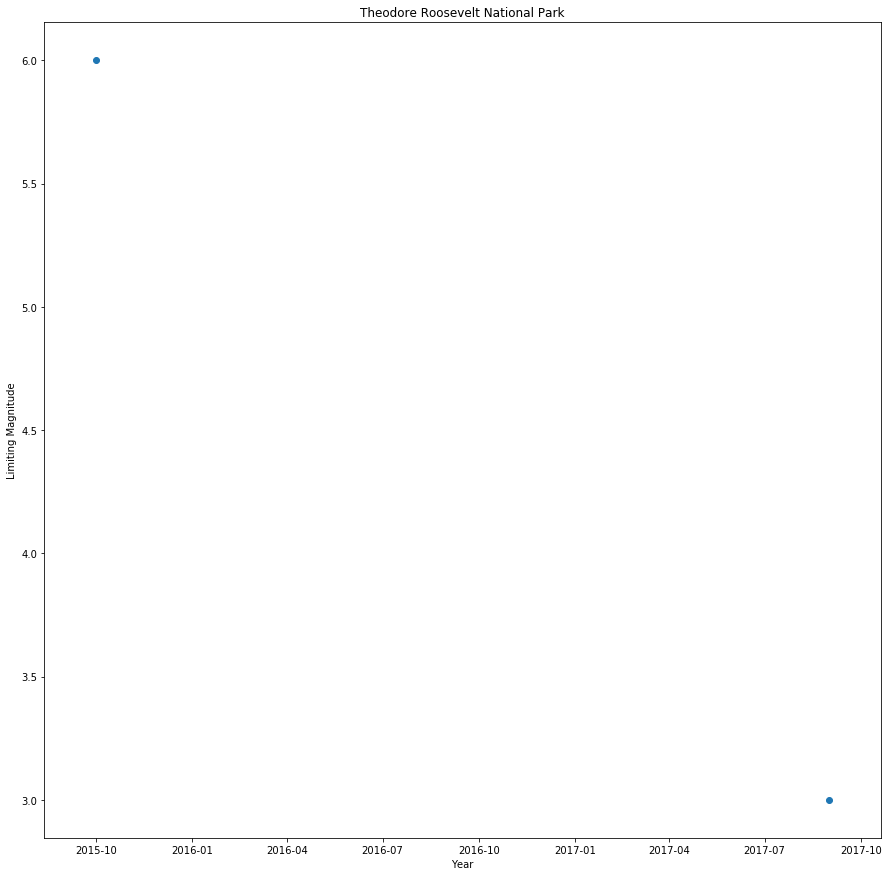

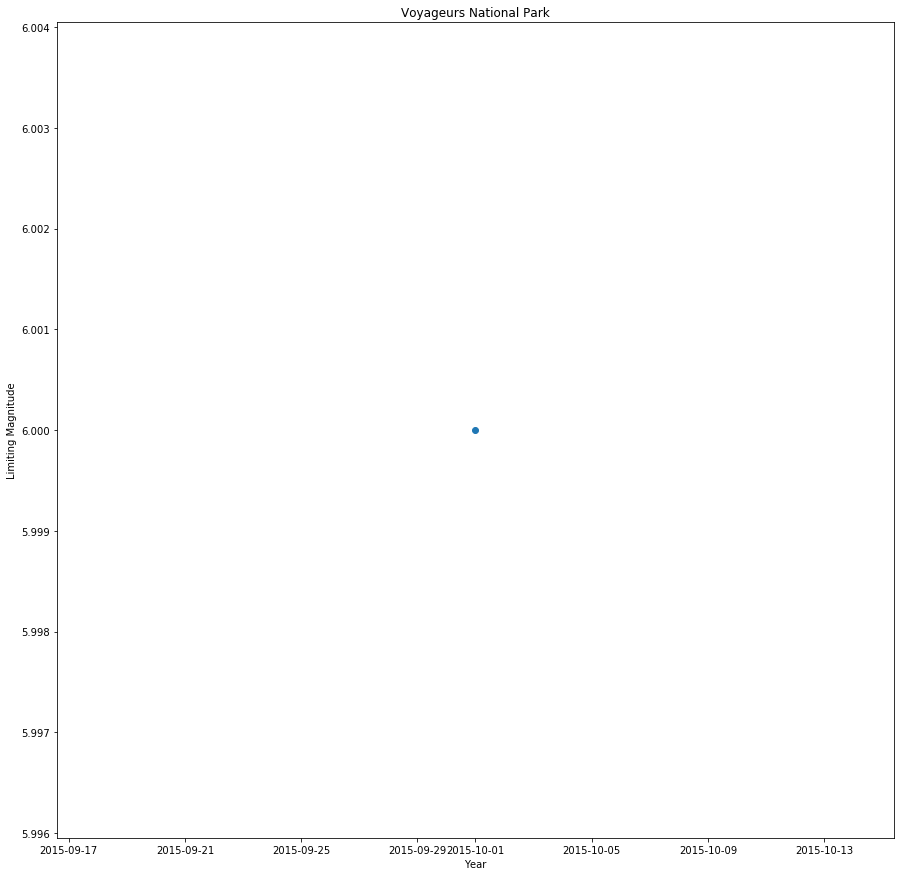

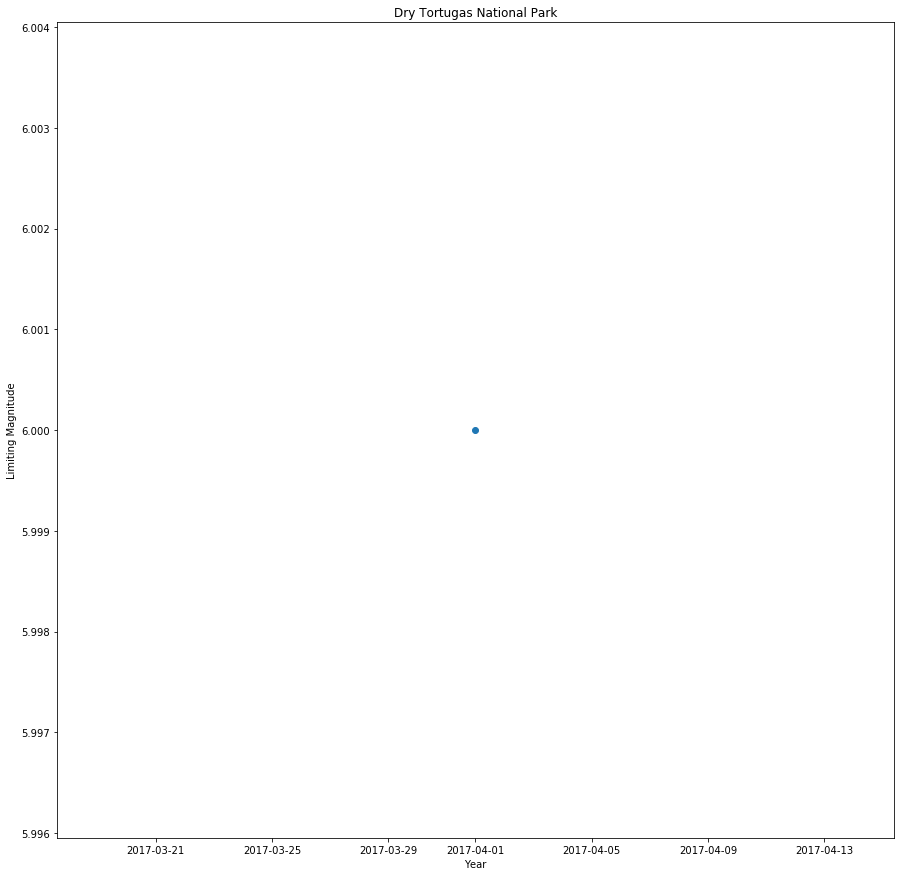

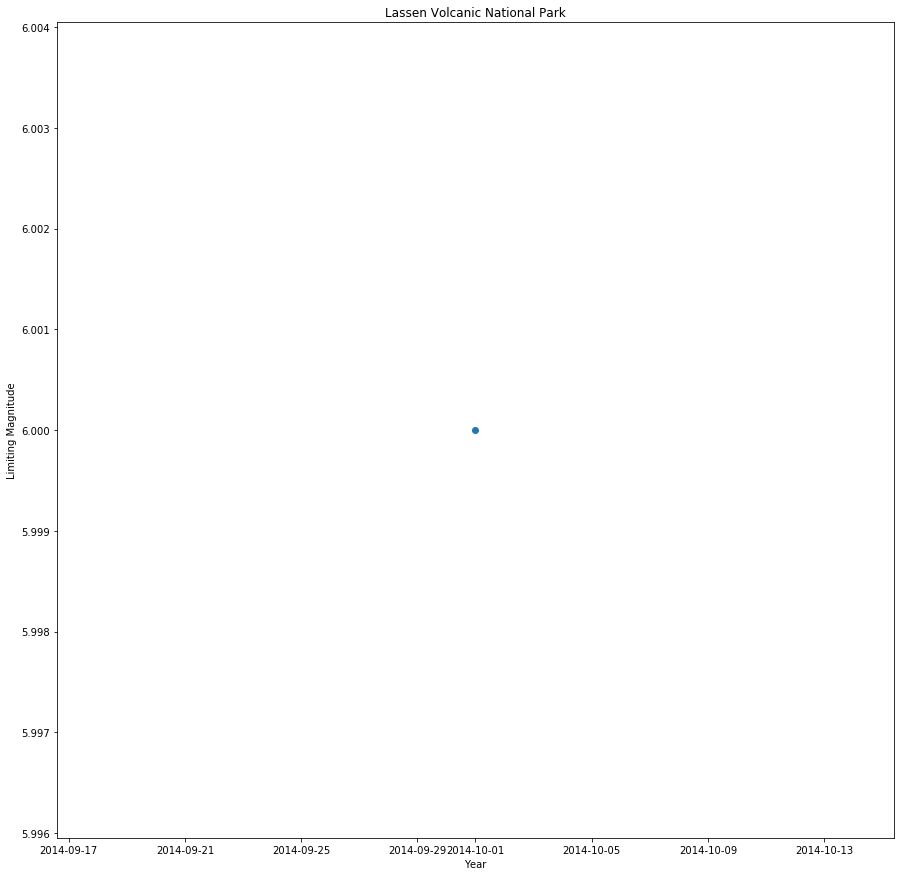

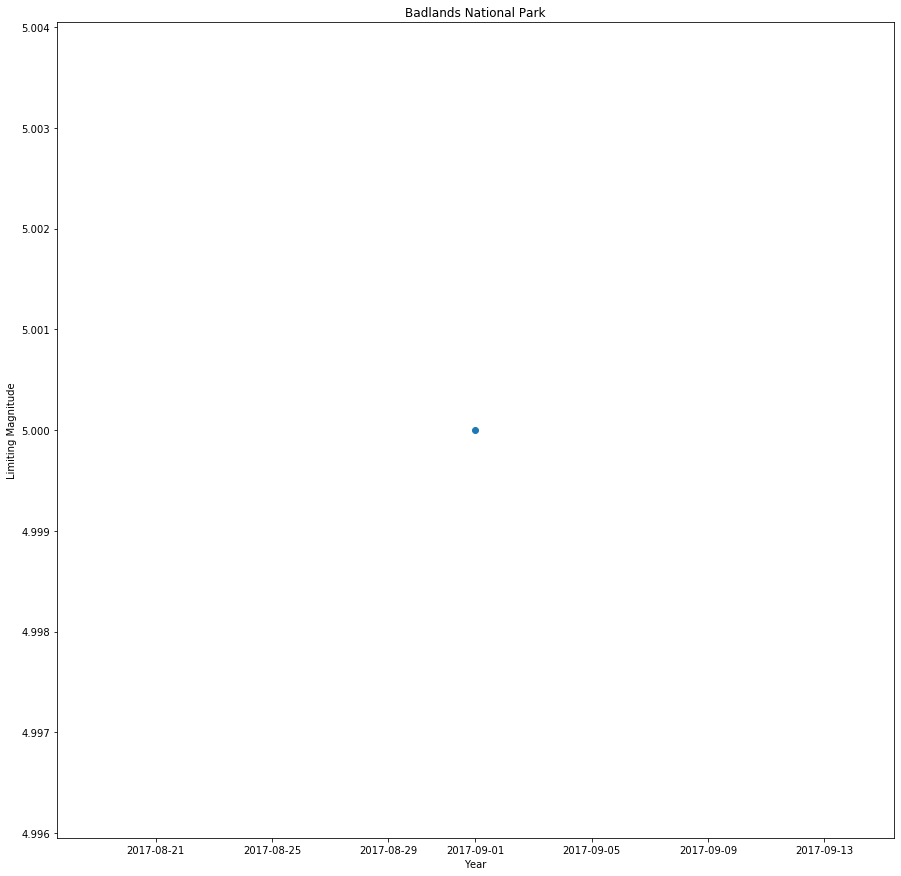

In [21]:
for park in dsd_agg.count().sort_values(ascending=False).index:
    plt.title(park)
    plt.scatter(dsd_agg.index, dsd_agg[park])
    plt.xlabel("Year")
    plt.ylabel("Limiting Magnitude")
    plt.rcParams["figure.figsize"] = (15,15)
    #plt.savefig(park + " Limiting Magnitude by Year.png") #ran just to generate images; don't want to run every time
    plt.show()